# Summary:
This notebook will cover performing **Latent Dirichlet Allocation (LDA)** analysis to embed abstract/bodytext with title/abstract/bodytext from the same paper as validation.

# Table of contents
* [1. preprocess text file](#Part1_link)
<br >&nbsp;&nbsp;&nbsp;[1.1 method1 -- WordNetLemmatizer](#Part1.1_link)
<br >&nbsp;&nbsp;&nbsp;[1.2 method2 -- ScispaCy](#Part1.2_link)
<br >&nbsp;&nbsp;&nbsp;[1.3 compare wordcount](#Part1.3_link)
* [2. Gensim dictionary, tfidf and LDA](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1 Abstract + preprocess method1](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.1 num_topics=10](#Part2.1.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.2 num_topics=20](#Part2.1.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.3 num_topics=30](#Part2.1.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.4 num_topics=40](#Part2.1.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.5 num_topics=50](#Part2.1.5_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.6 num_topics=100](#Part2.1.6_link)
<br >&nbsp;&nbsp;&nbsp;[2.2 Body_text + preprocess method1](#Part2.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.1 num_topics=10](#Part2.2.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.2 num_topics=20](#Part2.2.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.3 num_topics=30](#Part2.2.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.4 num_topics=40](#Part2.2.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.5 num_topics=50](#Part2.2.5_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.6 num_topics=100](#Part2.2.6_link)
<br >&nbsp;&nbsp;&nbsp;[2.3 Abstract + preprocess method2 (spaCy)](#Part2.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.1 num_topics=10](#Part2.3.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.2 num_topics=20](#Part2.3.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.3 num_topics=30](#Part2.3.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.4 num_topics=40](#Part2.3.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.5 num_topics=50](#Part2.3.5_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.6 num_topics=100](#Part2.3.6_link)
<br >&nbsp;&nbsp;&nbsp;[2.4 Body_text + preprocess method2 (spaCy)](#Part2.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.1 num_topics=10](#Part2.4.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.2 num_topics=20](#Part2.4.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.3 num_topics=30](#Part2.4.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.4 num_topics=40](#Part2.4.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.5 num_topics=50](#Part2.4.5_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.6 num_topics=100](#Part2.4.6_link)
* [3. Evaluate LDA models](#Part3_link)
<br >&nbsp;&nbsp;&nbsp;[3.1 Distribution of number of papers in each topic](#Part3.1_link)
<br >&nbsp;&nbsp;&nbsp;[3.2 Evaluate the topic prediction performance of LDA models](#Part3.2_link)
<br >&nbsp;&nbsp;&nbsp;[3.3 Compute cosine similarity for titles, abstracts and bodytext of each paper](#Part3.3_link)
<br >&nbsp;&nbsp;&nbsp;[3.4 Evaluate cosine similarity](#Part3.4_link)
* [4. Visualize keywords in each LDA topic using WordCloud](#Part4_link)

In [24]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import time
import json
import glob
from ast import literal_eval
from tqdm import tqdm

import gensim
import nltk
from nltk.stem import WordNetLemmatizer

import spacy
import scispacy
import en_core_sci_lg

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import cohen_kappa_score
import joblib
import glob
from collections import OrderedDict

from wordcloud import WordCloud
from wordcloud import STOPWORDS
import pickle

In [2]:
base_dir="/Volumes/Yuchen_Drive/COVID19/CORD19"

In [3]:
data_df=pd.read_csv(os.path.join(base_dir,"COVD19_meta_21423_text_df.csv"),index_col="paper_id",
                    dtype={"pubmed_id":str},
                    parse_dates=["publish_time"],usecols=["title","abstract","body_text","pubmed_id","publish_time","journal","paper_id"])


In [4]:
print(data_df.shape)
data_df.head()

(21423, 6)


,title,abstract,body_text,pubmed_id,publish_time,journal
paper_id,,,,,,
00142f93c18b07350be89e96372d240372437ed9,immunity to pathogens taught by specialized hu...,Dendritic cells (DCs) are specialized antigen-...,iNTRODUCTiON Human beings are constantly expos...,26528289,2015-10-13,Front Immunol
0022796bb2112abd2e6423ba2d57751db06049fb,Public Health Responses to and Challenges for ...,Dengue has a negative impact in low-and lower ...,Pathogens and vectors can now be transported r...,27643596,2016-09-19,PLoS Negl Trop Dis
0031e47b76374e05a18c266bd1a1140e5eacb54f,The fecal microbiota of healthy donor horses a...,"Fecal microbial transplantation (FMT), a treat...",a1111111111 a1111111111 a1111111111 a111111111...,32155205,2020-03-10,PLoS One
00326efcca0852dc6e39dc6b7786267e1bc4f194,a section of the journal Frontiers in Pediatri...,"Fifteen years ago, United Nations world leader...",In addition to preventative care and nutrition...,26925393,2016-02-18,Front Pediatr
00352a58c8766861effed18a4b079d1683fec2ec,MINI REVIEW Function of the Deubiquitinating E...,Posttranslational modification of proteins by ...,Ubiquitination is a widely used posttranslatio...,29302259,2017-12-14,Front Synaptic Neurosci


<a id='Part1_link'></a>
## 1. preprocess text file

In [5]:
abstract2_TF_pre=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_abstract2_TF_pre_df.csv"),index_col="token_id")
abstract2_DF=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_abstract2_DF_df.csv"),index_col="token_id")
abstract3_TF_pre=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_abstract3_TF_pre_df.csv"),index_col="token_id")
abstract3_DF=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_abstract3_DF_df.csv"),index_col="token_id")

bodytext2_TF_pre=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_bodytext2_TF_pre_df.csv"),index_col="token_id")
bodytext2_DF=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_bodytext2_DF_df.csv"),index_col="token_id")
bodytext3_TF_pre=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_bodytext3_TF_pre_df.csv"),index_col="token_id")
bodytext3_DF=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_bodytext3_DF_df.csv"),index_col="token_id")

/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
list0 = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 'rights', 'reserved', 
    'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', '-PRON-'
]

In [7]:
list1=list(abstract2_TF_pre.loc[abstract2_TF_pre.counts>10000].word.values)
list2=list(abstract2_DF.loc[abstract2_DF.counts>6000].word.values)
list3=list(abstract3_TF_pre.loc[abstract3_TF_pre.counts>9000].word.values)
list4=list(abstract3_DF.loc[abstract3_DF.counts>5000].word.values)
list5=list(bodytext2_TF_pre.loc[bodytext2_TF_pre.counts>100000].word.values)
list6=list(bodytext2_DF.loc[bodytext2_DF.counts>15000].word.values)
list7=list(bodytext3_TF_pre.word.values[:20])
list8=list(bodytext3_DF.loc[bodytext3_DF.counts>15000].word.values)
custom_words=set(list0+list1+list2+list3+list4+list5+list6+list7+list8)
print("Number of custom words: {}".format(len(custom_words)))

Number of custom words: 104


In [8]:
custom_words=[i.lower() for i in custom_words]

<a id='Part1.1_link'></a>
### 1.1 method1 -- WordNetLemmatizer

In [9]:
stop_word1 = gensim.parsing.preprocessing.STOPWORDS   ## 337
stop_word2 = nltk.corpus.stopwords.words('english')   ## 179
#stop_words = set(list(stop_word1)+stop_word2+list(punctuation))   ## 390+32=422
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
stop_words = set(list(stop_word1)+stop_word2+list(punct)+list(custom_words))
print(len(stop_words))

546


In [10]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        temp=WordNetLemmatizer().lemmatize(token).lower()
        if len(temp)>1 and temp not in stop_words:
            result.append(temp)
    return result

In [11]:
data_df["abstract2"]=data_df.abstract.apply(lambda x:preprocess(x))
data_df["body_text2"]=data_df.body_text.apply(lambda x:preprocess(x))
data_df["title2"]=data_df.title.apply(lambda x:preprocess(x))

<a id='Part1.2_link'></a>
### 1.2 method2 -- ScispaCy

In [12]:
nlp = spacy.load("en_core_sci_lg",disable=["tagger","parser","ner"])

In [14]:
nlp.max_length=2000000

In [15]:
for token in stop_words:
    nlp.vocab[token].is_stop=True

In [140]:
def spacy_tokenizer(text):
    words=[token.lemma_.lower() for token in nlp(text) if not (token.like_num or token.is_stop or token.is_punct or token.is_space or len(token)==1)]
    return [token for token in words if token not in stop_words]

In [141]:
data_df["abstract3"]=data_df.abstract.apply(lambda x:spacy_tokenizer(x))
data_df["body_text3"]=data_df.body_text.apply(lambda x:spacy_tokenizer(x))
data_df["title3"]=data_df.title.apply(lambda x:spacy_tokenizer(x))


<a id='Part1.3_link'></a>
### 1.3 compare wordcount

In [142]:
data_df["abstract2_wordcount"]=data_df.abstract2.apply(lambda x:len(x))
data_df["bodytext2_wordcount"]=data_df.body_text2.apply(lambda x:len(x))
data_df["title2_wordcount"]=data_df.title2.apply(lambda x:len(x))
data_df["abstract3_wordcount"]=data_df.abstract3.apply(lambda x:len(x))
data_df["bodytext3_wordcount"]=data_df.body_text3.apply(lambda x:len(x))
data_df["title3_wordcount"]=data_df.title3.apply(lambda x:len(x))

Text(0, 0.5, 'Density')

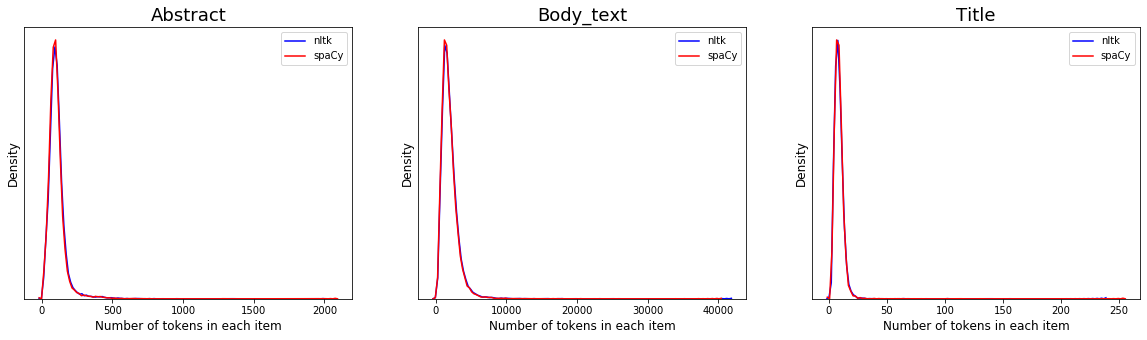

In [143]:
fig,axes=plt.subplots(1,3,figsize=(20,5))
sns.distplot(data_df.abstract2_wordcount,color="blue",ax=axes[0],hist=False,label="nltk")
sns.distplot(data_df.abstract3_wordcount,color="red",ax=axes[0],hist=False,label="spaCy")
sns.distplot(data_df.bodytext2_wordcount,color="blue",ax=axes[1],hist=False,label="nltk")
sns.distplot(data_df.bodytext3_wordcount,color="red",ax=axes[1],hist=False,label="spaCy")
sns.distplot(data_df.title2_wordcount,color="blue",ax=axes[2],hist=False,label="nltk")
sns.distplot(data_df.title3_wordcount,color="red",ax=axes[2],hist=False,label="spaCy")

axes[0].set_title("Abstract",fontsize=18)
axes[0].set_xlabel("Number of tokens in each item",fontsize=12)
axes[0].set_yticks([])
axes[0].set_ylabel("Density",fontsize=12)

axes[1].set_title("Body_text",fontsize=18)
axes[1].set_xlabel("Number of tokens in each item",fontsize=12)
axes[1].set_yticks([])
axes[1].set_ylabel("Density",fontsize=12)

axes[2].set_title("Title",fontsize=18)
axes[2].set_xlabel("Number of tokens in each item",fontsize=12)
axes[2].set_yticks([])
axes[2].set_ylabel("Density",fontsize=12)

In [145]:
data_df.loc[:,["abstract2_wordcount","bodytext2_wordcount","title2_wordcount","abstract3_wordcount","bodytext3_wordcount","title3_wordcount"]].describe()


,abstract2_wordcount,bodytext2_wordcount,title2_wordcount,abstract3_wordcount,bodytext3_wordcount,title3_wordcount
count,21423.000000,21423.000000,21423.000000,21423.000000,21423.000000,21423.000000
mean,107.929095,1991.815245,8.582318,104.576903,1940.511693,8.590674
std,69.664103,1336.398555,5.010793,68.938066,1305.031507,4.971873
min,0.000000,9.000000,0.000000,0.000000,10.000000,0.000000
25%,73.000000,1216.000000,6.000000,70.000000,1182.000000,6.000000
50%,99.000000,1744.000000,8.000000,96.000000,1695.000000,8.000000
75%,128.000000,2458.000000,11.000000,124.000000,2399.000000,10.000000
max,1988.000000,41475.000000,237.000000,2075.000000,40040.000000,254.000000


In [144]:
data_df.to_csv(os.path.join(base_dir,"COVD19_meta_21423_text_all_df.csv"),index=True)

<a id='Part2_link'></a>
## 2. Gensim dictionary, tfidf and LDA

In [24]:
def print_cfs_top(bow_dict,top_n):
    top={i:freq for i,freq in sorted(bow_dict.cfs.items(),key=lambda x:x[1],reverse=True)[:top_n]}
    print("Words with the highest term frequency:")
    for id,count in top.items():
        print("id: {}, word: {}, count: {}".format(id,bow_dict[id],count))

In [25]:
def print_cfs_bottom(bow_dict,bottom_n):
    bottom={i:freq for i,freq in sorted(bow_dict.cfs.items(),key=lambda x:x[1])[:bottom_n]}
    print("Words with the least term frequency:")
    for id,count in bottom.items():
        print("id: {}, word: {}, count: {}".format(id,bow_dict[id],count))

In [26]:
def generate_TF_df(bow_dict):
    word_dict={}
    count_dict={}
    for i in range(len(bow_dict)):
        word_dict[i]=bow_dict[i]
        count_dict[i]=bow_dict.cfs[i]
    df1=pd.DataFrame.from_dict(word_dict,orient="index",columns=["word"])
    df2=pd.DataFrame.from_dict(count_dict,orient="index",columns=["counts"])
    output=pd.concat([df1,df2],axis=1,sort=False)
    output.sort_values(by=["counts"],ascending=False,inplace=True)
    return output

In [27]:
def print_dfs_top(bow_dict,top_n):
    top={i:freq for i,freq in sorted(bow_dict.dfs.items(),key=lambda x:x[1],reverse=True)[:top_n]}
    print("Words with the highest document frequency:")
    for id,count in top.items():
        print("id: {}, word: {}, count: {}".format(id,bow_dict[id],count))

In [28]:
def print_dfs_bottom(bow_dict,bottom_n):
    bottom={i:freq for i,freq in sorted(bow_dict.cfs.items(),key=lambda x:x[1])[:bottom_n]}
    print("Words with the least document frequency:")
    for id,count in bottom.items():
        print("id: {}, word: {}, count: {}".format(id,bow_dict[id],count))

In [29]:
def generate_DF_df(bow_dict):
    word_dict={}
    count_dict={}
    for i in range(len(bow_dict)):
        word_dict[i]=bow_dict[i]
        count_dict[i]=bow_dict.dfs[i]
    df1=pd.DataFrame.from_dict(word_dict,orient="index",columns=["word"])
    df2=pd.DataFrame.from_dict(count_dict,orient="index",columns=["counts"])
    output=pd.concat([df1,df2],axis=1,sort=False)
    output.sort_values(by=["counts"],ascending=False,inplace=True)
    return output

In [30]:
## print_topics_method2
def print_top_words_lda(lda,bow_dict,n_top_words,print_message=True):
    topic_term_matrix=lda.get_topics()
    num_topics=topic_term_matrix.shape[0]
    topic_term_df=pd.DataFrame(topic_term_matrix,columns=list(bow_dict.values()),index=np.array(["topic"+str(i) for i in range(num_topics)]))
    words_dict={}
    scores_dict={}
    topics_dict={}
    for i in range(num_topics):
        indices=topic_term_df.iloc[i,:].values.argsort()[-n_top_words:][::-1]
        words=topic_term_df.columns[indices].values
        scores=topic_term_df.iloc[i,indices].values
        words_dict["topic"+str(i)]=words
        scores_dict["topic"+str(i)]=scores
        topics_dict["topic"+str(i)]=OrderedDict([(words[i],scores[i]) for i in range(n_top_words)])
        if print_message:
            message="Topic"+str(i)+": "+" ".join(words)
            print(message)
    words_df=pd.DataFrame.from_dict(words_dict)
    scores_df=pd.DataFrame.from_dict(scores_dict)
    topics_df=pd.DataFrame(topics_dict)
    topics_df=topics_df.fillna(0).T
    return words_df,scores_df,topics_df

In [31]:
def lda_query(query_df,bow_dict,tfidf,lda):
    #query_preprocess=preprocess(query)
    #bow_dict=gensim.corpora.Dictionary.load(os.path.join(base_dir, '{}_bow_dict.dict'.format(prefix)))
    #tfidf=gensim.models.TfidfModel.load(os.path.join(base_dir, '{}_tfidf.tfidf'.format(prefix)))
    #lda = gensim.models.LdaMulticore.load(os.path.join(base_dir, '{}_lda.lda'.format(prefix)))
    output_dict={}
    for i in range(query_df.shape[0]):
        query_corpus=[bow_dict.doc2bow(query_df.iloc[i,0])]
        query_tfidf=tfidf[query_corpus]
        query_lda=lda.get_document_topics(query_tfidf,minimum_probability=0.0)
        query_lda = gensim.matutils.corpus2csc(query_lda)
        query_lda = query_lda.T.toarray().squeeze()
        #np.argmax(query_lda)
        output_dict[query_df.index[i]]=query_lda
    output_df=pd.DataFrame.from_dict(output_dict,orient="index",columns=["topic{}".format(i) for i in range(len(query_lda))])
    return output_df

In [32]:
def pred_rank(ldavector_df,pred_df,num_topics):
    pred_df["pred"]=ldavector_df.pred
    pred_df["rank"]=pred_df.apply(lambda x:num_topics-np.argwhere(x.values[:num_topics].argsort()==x.pred)[0][0],axis=1)
    return pred_df

<a id='Part2.1_link'></a>
### 2.1 Abstract + preprocess method1

In [33]:
## generate dictionary
bow_dict=gensim.corpora.Dictionary(data_df.abstract2)

In [34]:
print(len(bow_dict))

62475


In [35]:
print_cfs_top(bow_dict,top_n=10)

Words with the highest term frequency:
id: 664, word: influenza, count: 8297
id: 134, word: health, count: 7619
id: 92, word: vaccine, count: 7372
id: 2045, word: cov, count: 7046
id: 1874, word: sars, count: 7041
id: 378, word: method, count: 6997
id: 586, word: host, count: 6850
id: 351, word: clinical, count: 6594
id: 61, word: pathogen, count: 6240
id: 524, word: model, count: 5831


In [36]:
abstract2_TF_pre=generate_TF_df(bow_dict)
abstract2_TF_pre.index.name="token_id"
print(abstract2_TF_pre.shape)
abstract2_TF_pre.head()

(62475, 2)


,word,counts
token_id,,
664,influenza,8297
134,health,7619
92,vaccine,7372
2045,cov,7046
1874,sars,7041


In [38]:
abstract2_TF_pre.to_csv(os.path.join(base_dir,"models_lda_v2/word_counts/COVD19_meta_21423_text_df_abstract2_TF_pre_df.csv"),index=True)


In [39]:
print_dfs_top(bow_dict,top_n=10)

Words with the highest document frequency:
id: 378, word: method, count: 4730
id: 351, word: clinical, count: 4036
id: 81, word: role, count: 3944
id: 139, word: including, count: 3867
id: 279, word: potential, count: 3733
id: 353, word: conclusion, count: 3693
id: 35, word: identified, count: 3542
id: 587, word: infectious, count: 3502
id: 382, word: new, count: 3470
id: 61, word: pathogen, count: 3465


In [40]:
abstract2_DF_pre=generate_DF_df(bow_dict)
abstract2_DF_pre.index.name="token_id"
print(abstract2_DF_pre.shape)
abstract2_DF_pre.head()


(62475, 2)


,word,counts
token_id,,
378,method,4730
351,clinical,4036
81,role,3944
139,including,3867
279,potential,3733


In [41]:
abstract2_DF_pre.to_csv(os.path.join(base_dir,"models_lda_v2/word_counts/COVD19_meta_21423_text_df_abstract2_DF_pre_df.csv"),index=True)


In [100]:
bow_dict.filter_extremes(no_below=2, no_above=0.8, keep_n=1000000)
#print('len(bow_dict): {}'.format(len(bow_dict)))
bow_dict.save(os.path.join(base_dir, 'models_lda_v2/COVD19_meta_21423_text_df_abstract2_bow_dict.dict'))

len(bow_dict): 31189


In [42]:
bow_dict=gensim.corpora.Dictionary.load(os.path.join(base_dir,"models_lda_v2/COVD19_meta_21423_text_df_abstract2_bow_dict.dict"))

In [43]:
print(len(bow_dict))

29677


In [45]:
abstract2_DF=generate_DF_df(bow_dict)
abstract2_DF.index.name="token_id"
print(abstract2_DF.shape)
abstract2_DF.to_csv(os.path.join(base_dir,"models_lda_v2/word_counts/COVD19_meta_21600_text_df_abstract2_DF_df.csv"),index=True)


(29677, 2)


In [46]:
## generate dictionary for each text file
data_df['bow_corpus']=data_df.abstract2.apply(lambda x:bow_dict.doc2bow(x))

In [47]:
## TF-IDF
#tfidf=gensim.models.TfidfModel(list(data_df.bow_corpus))
#tfidf.save(os.path.join(base_dir, 'models_lda_v2/COVD19_meta_21423_text_df_abstract2_tfidf.tfidf'))
tfidf=gensim.models.TfidfModel.load(os.path.join(base_dir,"models_lda_v2/COVD19_meta_21423_text_df_abstract2_tfidf.tfidf"))
bow_tfidf=tfidf[list(data_df.bow_corpus)]
print(len(bow_tfidf))

21423


<a id='Part2.1.1_link'></a>
#### 2.1.1 num_topics=10

In [48]:
num_topics=10
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=10, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract2_lda10.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract2_lda10.lda"))

In [49]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(10)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 10)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred
paper_id,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.012666,0.012665,0.012669,0.012670,0.760588,0.138069,0.012668,0.012665,0.012666,0.012675,4
0022796bb2112abd2e6423ba2d57751db06049fb,0.011295,0.011288,0.011289,0.022333,0.011288,0.011290,0.011292,0.011288,0.887347,0.011290,8
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.017665,0.017668,0.017667,0.543911,0.017669,0.017665,0.017667,0.017668,0.314755,0.017664,3
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.012728,0.012727,0.012729,0.751787,0.012729,0.012729,0.146383,0.012729,0.012730,0.012728,3
00352a58c8766861effed18a4b079d1683fec2ec,0.017808,0.017808,0.017808,0.017808,0.684461,0.173074,0.017810,0.017808,0.017808,0.017807,4


In [50]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_ldavector10_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_ldavector10_df.csv"),index_col="paper_id")

In [51]:
topic_counts_df1=ldavector_df.pred.value_counts().to_frame()
topic_counts_df1.head()

,pred
6,5129
4,4675
3,3939
7,2454
2,1983


In [52]:
pred_df=lda_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.842832469775475


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.031318,0.031316,0.031319,0.031319,0.469121,0.031319,0.031321,0.031318,0.280330,0.031318,4,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.028474,0.028473,0.028476,0.028480,0.028473,0.028479,0.028479,0.028474,0.743716,0.028475,8,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.023534,0.023541,0.023538,0.624783,0.023541,0.023535,0.023535,0.023540,0.186919,0.023534,3,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.021562,0.021563,0.021565,0.508811,0.021563,0.021565,0.021565,0.021569,0.318672,0.021563,3,1
00352a58c8766861effed18a4b079d1683fec2ec,0.026617,0.026617,0.026625,0.026620,0.512912,0.274119,0.026629,0.026621,0.026621,0.026620,4,1


In [53]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda10_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda10_df.csv"),index_col="paper_id")


In [54]:
pred_df=lda_query(data_df.loc[:,["body_text2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9262008122111749


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.008660,0.008658,0.008665,0.008658,0.922050,0.008677,0.008663,0.008657,0.008655,0.008657,4,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.006661,0.006660,0.006661,0.577188,0.006660,0.006667,0.210570,0.165604,0.006667,0.006663,8,4
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.009202,0.009209,0.009206,0.475875,0.308828,0.009203,0.009204,0.009211,0.150863,0.009200,3,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.005815,0.005813,0.005814,0.701829,0.005813,0.216164,0.005813,0.005813,0.041314,0.005813,3,1
00352a58c8766861effed18a4b079d1683fec2ec,0.013729,0.013703,0.013720,0.013718,0.545475,0.169856,0.188666,0.013708,0.013713,0.013710,4,1


In [55]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda10_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda10_df.csv"),index_col="paper_id")

In [56]:
for idx, topic in lda_model_tfidf.print_topics():
    print('Topic: {}'.format(idx))
    print('Words: {}'.format(topic))
    print('')

Topic: 0
Words: 0.002*"health" + 0.002*"mers" + 0.002*"cov" + 0.001*"sars" + 0.001*"pcv" + 0.001*"outbreak" + 0.001*"model" + 0.001*"epidemic" + 0.001*"transmission" + 0.001*"host"

Topic: 1
Words: 0.006*"bat" + 0.002*"cov" + 0.002*"hcov" + 0.001*"hku" + 0.001*"influenza" + 0.001*"specie" + 0.001*"coronavirus" + 0.001*"sars" + 0.001*"detected" + 0.001*"coronaviruses"

Topic: 2
Words: 0.005*"mers" + 0.005*"cov" + 0.003*"sars" + 0.002*"vaccine" + 0.002*"influenza" + 0.002*"pedv" + 0.002*"coronavirus" + 0.002*"health" + 0.002*"calf" + 0.002*"pneumonia"

Topic: 3
Words: 0.004*"vaccine" + 0.003*"influenza" + 0.003*"ibv" + 0.002*"infectious" + 0.002*"health" + 0.002*"vaccination" + 0.002*"pandemic" + 0.002*"sars" + 0.002*"pathogen" + 0.002*"risk"

Topic: 4
Words: 0.004*"ifn" + 0.003*"cd" + 0.003*"il" + 0.003*"immune" + 0.002*"cat" + 0.002*"host" + 0.002*"pathway" + 0.002*"mhv" + 0.002*"cytokine" + 0.002*"macrophage"

Topic: 5
Words: 0.004*"sars" + 0.002*"health" + 0.002*"cov" + 0.002*"frames

In [57]:
words_df,scores_df,topics_df=print_top_words_lda(lda_model_tfidf,bow_dict,n_top_words=10)

Topic0: health mers cov sars pcv outbreak model epidemic transmission host
Topic1: bat cov hcov hku influenza specie coronavirus sars detected coronaviruses
Topic2: mers cov sars vaccine influenza pedv coronavirus health calf pneumonia
Topic3: vaccine influenza ibv infectious health vaccination pandemic sars pathogen risk
Topic4: ifn cd il immune cat host pathway mhv cytokine macrophage
Topic5: sars health cov frameshifting outbreak mers public hospital method care
Topic6: sars cov structure genome membrane host peptide domain binding fusion
Topic7: pcr child rsv assay influenza clinical rt detection positive detected
Topic8: health public zikv global influenza care outbreak pandemic vaccine policy
Topic9: asthma hajj pilgrim child influenza health mers vaccine rv gathering


In [58]:
words_df.head()

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,health,bat,mers,vaccine,ifn,sars,sars,pcr,health,asthma
1,mers,cov,cov,influenza,cd,health,cov,child,public,hajj
2,cov,hcov,sars,ibv,il,cov,structure,rsv,zikv,pilgrim
3,sars,hku,vaccine,infectious,immune,frameshifting,genome,assay,global,child
4,pcv,influenza,influenza,health,cat,outbreak,membrane,influenza,influenza,influenza


In [59]:
scores_df.head()

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,0.001722,0.005553,0.004834,0.003799,0.003728,0.003666,0.002881,0.003800,0.003764,0.001869
1,0.001720,0.001873,0.004812,0.003497,0.002769,0.002186,0.002454,0.003659,0.002043,0.001556
2,0.001505,0.001668,0.003017,0.002802,0.002695,0.002163,0.002155,0.003342,0.001756,0.001476
3,0.001433,0.001467,0.002459,0.001769,0.002637,0.001755,0.002051,0.003297,0.001558,0.001472
4,0.001395,0.001449,0.002430,0.001747,0.002334,0.001480,0.002010,0.003001,0.001533,0.001200


<a id='Part2.1.2_link'></a>
#### 2.1.2 num_topics=20

In [60]:
num_topics=20
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=20, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract2_lda20.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract2_lda20.lda"))

In [61]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(20)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 20)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.000000,0.0,0.0,0.0,0.162585,0.0,0.000000,0.0,0.0,0.284094,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,10
0022796bb2112abd2e6423ba2d57751db06049fb,0.789954,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.102398,0.0,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.000000,0.0,0.0,0.0,0.000000,0.0,0.412041,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.423969,0.000000,0.0,0.000000,0.0,15
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.790237,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.095479,0.0,0.000000,0.0,0
00352a58c8766861effed18a4b079d1683fec2ec,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.535669,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,9


In [62]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_ldavector20_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_ldavector20_df.csv"),index_col="paper_id")

In [63]:
topic_counts_df2=ldavector_df.pred.value_counts().to_frame()
topic_counts_df2.head()

,pred
2,4088
0,4057
1,2355
9,1558
15,1512


In [64]:
pred_df=lda_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.6852448303225506


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.439142,0.015654,0.015654,0.015654,0.015654,0.015654,0.015654,0.015654,0.015654,0.015654,...,0.015654,0.015654,0.015654,0.015654,0.015654,0.015654,0.015654,0.015654,10,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.729544,0.014235,0.014235,0.014235,0.014235,0.014235,0.014235,0.014235,0.014235,0.014235,...,0.014235,0.014235,0.014235,0.014235,0.014235,0.014235,0.014235,0.014235,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.011755,0.011755,0.011755,0.011755,0.011755,0.011755,0.307979,0.011755,0.011755,0.011755,...,0.011755,0.011755,0.011755,0.480424,0.011755,0.011755,0.011755,0.011755,15,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.711446,0.010794,0.010794,0.010794,0.010794,0.010794,0.010794,0.094265,0.010794,0.010794,...,0.010794,0.010794,0.010794,0.010794,0.010794,0.010794,0.010794,0.010794,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.013293,0.013293,0.013293,0.013293,0.013293,0.013293,0.013293,0.013293,0.013293,0.548413,...,0.013293,0.013293,0.013293,0.013293,0.013293,0.013293,0.013293,0.013293,9,1


In [65]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda20_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda20_df.csv"),index_col="paper_id")


In [66]:
pred_df=lda_query(data_df.loc[:,["body_text2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.8896513093404285


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.004276,0.004276,0.004276,0.004276,0.091492,0.004276,0.004276,0.004276,0.004276,0.349340,...,0.004276,0.004276,0.004276,0.004276,0.004276,0.004276,0.004276,0.004276,10,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.610337,0.003452,0.131017,0.071261,0.003452,0.003452,0.003452,0.003452,0.003452,0.003452,...,0.003452,0.061653,0.003452,0.003452,0.003452,0.003452,0.073950,0.003452,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.195910,0.004852,0.368134,0.004852,0.004852,0.004852,0.004852,0.004852,0.004852,0.004852,...,0.004852,0.004852,0.004852,0.353473,0.004852,0.004852,0.004852,0.004852,15,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.750137,0.003044,0.134135,0.003044,0.003044,0.003044,0.003044,0.003044,0.003044,0.003044,...,0.003044,0.063979,0.003044,0.003044,0.003044,0.003044,0.003044,0.003044,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.567836,...,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,0.007463,9,1


In [67]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda20_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda20_df.csv"),index_col="paper_id")

<a id='Part2.1.3_link'></a>
#### 2.1.3 num_topics=30

In [68]:
num_topics=30
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=30, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract2_lda30.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract2_lda30.lda"))


In [69]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(30)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 30)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic21,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.0,0.000000,0.408437,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.447131,0.0,0.0,27
0022796bb2112abd2e6423ba2d57751db06049fb,0.0,0.525295,0.000000,0.0,0.0,0.0,0.0,0.36631,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,17
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.74897,0.0,0.0,...,0.0,0.0,0.0,0.0,0.132679,0.0,0.000000,0.0,0.0,7
00352a58c8766861effed18a4b079d1683fec2ec,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.824291,0.0,0.000000,0.0,0.0,25


In [70]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_ldavector30_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_ldavector30_df.csv"),index_col="paper_id")

In [71]:
topic_counts_df3=ldavector_df.pred.value_counts().to_frame()
topic_counts_df3.head()

,pred
2,8162
7,3112
5,2991
27,2215
8,763


In [72]:
pred_df=lda_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.5362460906502358


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.013310,0.013310,0.614024,0.013310,0.013310,0.013310,0.013310,0.013310,0.013310,0.013310,...,0.013310,0.013310,0.013310,0.013310,0.013310,0.013310,0.013310,0.013310,27,29
0022796bb2112abd2e6423ba2d57751db06049fb,0.009490,0.724796,0.009490,0.009490,0.009490,0.009490,0.009490,0.009490,0.009490,0.009490,...,0.009490,0.009490,0.009490,0.009490,0.009490,0.009490,0.009490,0.009490,1,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.007834,0.007834,0.007834,0.007834,0.007834,0.007834,0.007834,0.007834,0.007834,0.007834,...,0.007834,0.007834,0.007834,0.007834,0.007834,0.007834,0.007834,0.007834,17,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.007201,0.007201,0.007201,0.007201,0.007201,0.007201,0.007201,0.317897,0.007201,0.007201,...,0.007201,0.007201,0.007201,0.007201,0.007201,0.398152,0.007201,0.007201,7,2
00352a58c8766861effed18a4b079d1683fec2ec,0.008880,0.008880,0.008880,0.008880,0.132940,0.008880,0.008880,0.008880,0.008880,0.008880,...,0.008880,0.008880,0.008880,0.618419,0.008880,0.008880,0.008880,0.008880,25,1


In [73]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda30_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda30_df.csv"),index_col="paper_id")


In [74]:
pred_df=lda_query(data_df.loc[:,["body_text2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9087896186341782


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.002857,0.002857,0.423767,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,...,0.002857,0.002857,0.002857,0.002857,0.002857,0.224498,0.002857,0.002857,27,3
0022796bb2112abd2e6423ba2d57751db06049fb,0.002352,0.039538,0.177847,0.002352,0.002352,0.002352,0.002352,0.459067,0.129990,0.029025,...,0.002352,0.002352,0.002352,0.002352,0.002352,0.108088,0.002352,0.002352,1,5
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.003301,0.003301,0.003301,0.003301,0.003301,0.317753,0.003301,0.191516,0.003301,0.003301,...,0.003301,0.003301,0.003301,0.003301,0.003301,0.003301,0.003301,0.003301,17,4
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.002079,0.002079,0.002079,0.002079,0.002079,0.130487,0.002079,0.684044,0.002079,0.002079,...,0.002079,0.002079,0.002079,0.002079,0.002079,0.129335,0.002079,0.002079,7,1
00352a58c8766861effed18a4b079d1683fec2ec,0.005223,0.005223,0.517031,0.005223,0.005223,0.005223,0.005223,0.005223,0.005223,0.005223,...,0.005223,0.005223,0.005223,0.336722,0.005223,0.005223,0.005223,0.005223,25,2


In [75]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda30_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda30_df.csv"),index_col="paper_id")


<a id='Part2.1.4_link'></a>
#### 2.1.4 num_topics=40

In [76]:
num_topics=40
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=40, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract2_lda40.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract2_lda40.lda"))

In [77]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(40)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 40)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic31,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.0,0.0,0.096675,0.0,0.000000,0.0,0.579534,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,6
0022796bb2112abd2e6423ba2d57751db06049fb,0.0,0.0,0.000000,0.0,0.292535,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,29
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,17
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.160463,0.0,0.0,0.0,0.0,0.0,29
00352a58c8766861effed18a4b079d1683fec2ec,0.0,0.0,0.000000,0.0,0.000000,0.0,0.482790,0.0,0.0,0.0,...,0.0,0.0,0.0,0.343899,0.0,0.0,0.0,0.0,0.0,6


In [78]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_ldavector40_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_ldavector40_df.csv"),index_col="paper_id")

In [79]:
topic_counts_df4=ldavector_df.pred.value_counts().to_frame()
topic_counts_df4.head()

,pred
17,6734
29,4152
6,2380
0,1971
4,1188


In [80]:
pred_df=lda_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.4964757503617607


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.007805,0.007805,0.007805,0.007805,0.007805,0.007805,0.472597,0.007805,0.007805,0.007805,...,0.007805,0.007805,0.007805,0.007805,0.007805,0.007805,0.007805,0.007805,6,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.007117,0.007117,0.007117,0.007117,0.007117,0.007117,0.007117,0.007117,0.007117,0.007117,...,0.007117,0.007117,0.007117,0.007117,0.007117,0.007117,0.007117,0.007117,29,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.005882,0.005882,0.005882,0.005882,0.005882,0.005882,0.005882,0.005882,0.005882,0.005882,...,0.005882,0.005882,0.005882,0.005882,0.005882,0.005882,0.005882,0.005882,17,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.005382,0.005382,0.005382,0.005382,0.005382,0.005382,0.203125,0.005382,0.005382,0.005382,...,0.005382,0.005382,0.005382,0.005382,0.005382,0.005382,0.005382,0.005382,29,1
00352a58c8766861effed18a4b079d1683fec2ec,0.006647,0.006647,0.006647,0.006647,0.006647,0.006647,0.006647,0.006647,0.006647,0.006647,...,0.006647,0.006647,0.155964,0.006647,0.006647,0.006647,0.006647,0.006647,6,15


In [81]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda40_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda40_df.csv"),index_col="paper_id")


In [82]:
pred_df=lda_query(data_df.loc[:,["body_text2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.8677122718573496


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.002233,0.002233,0.159235,0.002233,0.002233,0.002233,0.614106,0.002233,0.002233,0.002233,...,0.002233,0.002233,0.002233,0.002233,0.002233,0.002233,0.002233,0.002233,6,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.001784,0.001784,0.001784,0.001784,0.142087,0.001784,0.001784,0.001784,0.001784,0.001784,...,0.001784,0.001784,0.073500,0.001784,0.001784,0.001784,0.001784,0.001784,29,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.002563,0.002563,0.002563,0.002563,0.002563,0.002563,0.002563,0.002563,0.002563,0.002563,...,0.002563,0.002563,0.002563,0.002563,0.002563,0.002563,0.002563,0.002563,17,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.123380,0.001579,0.001579,0.001579,0.086317,0.001579,0.001579,0.001579,0.001579,0.001579,...,0.001579,0.001579,0.001579,0.001579,0.001579,0.001579,0.001579,0.001579,29,1
00352a58c8766861effed18a4b079d1683fec2ec,0.003933,0.003933,0.003933,0.003933,0.003933,0.003933,0.442022,0.003933,0.003933,0.003933,...,0.003933,0.003933,0.212840,0.003933,0.003933,0.003933,0.003933,0.003933,6,1


In [83]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda40_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda40_df.csv"),index_col="paper_id")


<a id='Part2.1.5_link'></a>
#### 2.1.5 num_topics=50

In [84]:
num_topics=50
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=50, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract2_lda50.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract2_lda50.lda"))


In [85]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(50)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 50)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic41,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.585398,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,41
0022796bb2112abd2e6423ba2d57751db06049fb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.886431,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,41
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.200127,29
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.752495,0.124815,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,41
00352a58c8766861effed18a4b079d1683fec2ec,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,18


In [86]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_ldavector50_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_ldavector50_df.csv"),index_col="paper_id")

In [87]:
topic_counts_df5=ldavector_df.pred.value_counts().to_frame()
topic_counts_df5.head()

,pred
41,4921
35,2872
26,2187
30,1769
40,1541


In [88]:
pred_df=lda_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.473883209634505


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.006233,0.006233,0.006233,0.006233,0.006233,0.006233,0.006233,0.006233,0.006233,0.006233,...,0.006233,0.006233,0.006233,0.006233,0.006233,0.006233,0.006233,0.006233,41,36
0022796bb2112abd2e6423ba2d57751db06049fb,0.005694,0.005694,0.005694,0.005694,0.005694,0.005694,0.005694,0.005694,0.005694,0.005694,...,0.005694,0.005694,0.005694,0.005694,0.005694,0.005694,0.005694,0.005694,41,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.004738,0.004738,0.004738,0.004738,0.004738,0.004738,0.004738,0.004738,0.004738,0.004738,...,0.004738,0.004738,0.004738,0.004738,0.004738,0.004738,0.004738,0.253629,29,3
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.072439,0.004328,0.004328,0.004328,0.004328,0.004328,0.004328,0.004328,0.004328,0.004328,...,0.004328,0.004328,0.004328,0.004328,0.004328,0.004328,0.004328,0.101621,41,1
00352a58c8766861effed18a4b079d1683fec2ec,0.005318,0.005318,0.005318,0.005318,0.005318,0.005318,0.005318,0.005318,0.005318,0.005318,...,0.005318,0.005318,0.005318,0.005318,0.005318,0.005318,0.005318,0.005318,18,1


In [89]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda50_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda50_df.csv"),index_col="paper_id")


In [90]:
pred_df=lda_query(data_df.loc[:,["body_text2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.8233674088596369


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.001752,0.001752,0.001752,0.001752,0.001752,0.001752,0.001752,0.001752,0.001752,0.001752,...,0.001752,0.001752,0.001752,0.001752,0.001752,0.001752,0.001752,0.001752,41,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.001481,0.001481,0.001481,0.001481,0.001481,0.001481,0.001481,0.072212,0.001481,0.001481,...,0.001481,0.001481,0.001481,0.001481,0.001481,0.001481,0.001481,0.001481,41,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.002057,0.002057,0.002057,0.002057,0.002057,0.002057,0.002057,0.002057,0.002057,0.002057,...,0.002057,0.002057,0.002057,0.002057,0.002057,0.002057,0.002057,0.189099,29,4
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.001268,0.001268,0.001268,0.001268,0.001268,0.001268,0.001268,0.107484,0.001268,0.001268,...,0.001268,0.001268,0.001268,0.001268,0.001268,0.001268,0.001268,0.001268,41,1
00352a58c8766861effed18a4b079d1683fec2ec,0.003252,0.003252,0.003252,0.003252,0.003252,0.003252,0.003252,0.003252,0.003252,0.003252,...,0.003252,0.003252,0.003252,0.003252,0.003252,0.003252,0.003252,0.003252,18,1


In [91]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda50_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda50_df.csv"),index_col="paper_id")

<a id='Part2.1.6_link'></a>
#### 2.1.6 num_topics=100

In [92]:
num_topics=100
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=100, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract2_lda100.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract2_lda100.lda"))


In [93]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(100)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 100)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic91,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87
0022796bb2112abd2e6423ba2d57751db06049fb,0.0,0.0,0.048945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.0,0.0,0.199997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77
00352a58c8766861effed18a4b079d1683fec2ec,0.0,0.0,0.343765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63


In [94]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_ldavector100_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_ldavector100_df.csv"),index_col="paper_id")

In [95]:
topic_counts_df6=ldavector_df.pred.value_counts().to_frame()
topic_counts_df6.head()

,pred
87,4886
77,4244
53,2196
23,1877
2,981


In [96]:
pred_df=lda_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.4292582738178593


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.003994,0.003994,0.003994,0.003994,0.003994,0.003994,0.003994,0.003994,0.003994,0.003994,...,0.003994,0.003994,0.003994,0.003994,0.003994,0.003994,0.003994,0.003994,87,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.002847,0.002847,0.002847,0.002847,0.002847,0.002847,0.002847,0.002847,0.002847,0.002847,...,0.002847,0.002847,0.002847,0.002847,0.002847,0.002847,0.002847,0.002847,77,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.002353,0.002353,0.002353,0.002353,0.002353,0.002353,0.002353,0.002353,0.002353,0.002353,...,0.002353,0.002353,0.002353,0.002353,0.002353,0.002353,0.002353,0.002353,88,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.002151,0.002151,0.283653,0.002151,0.002151,0.002151,0.002151,0.002151,0.002151,0.002151,...,0.002151,0.002151,0.002151,0.002151,0.002151,0.002151,0.002151,0.002151,77,2
00352a58c8766861effed18a4b079d1683fec2ec,0.002870,0.002870,0.002870,0.002870,0.002870,0.002870,0.002870,0.002870,0.002870,0.002870,...,0.002870,0.002870,0.002870,0.002870,0.138461,0.002870,0.002870,0.002870,63,2


In [97]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda100_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda100_df.csv"),index_col="paper_id")


In [98]:
pred_df=lda_query(data_df.loc[:,["body_text2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.8279886103720301


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.000901,0.000901,0.000901,0.000901,0.000901,0.000901,0.000901,0.000901,0.000901,0.000901,...,0.000901,0.109980,0.000901,0.000901,0.000901,0.000901,0.000901,0.000901,87,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.000772,0.000772,0.000772,0.000772,0.000772,0.000772,0.000772,0.000772,0.000772,0.000772,...,0.000772,0.000772,0.000772,0.000772,0.000772,0.000772,0.000772,0.000772,77,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.001082,0.001082,0.001082,0.001082,0.001082,0.001082,0.001082,0.001082,0.001082,0.001082,...,0.001082,0.001082,0.001082,0.001082,0.001082,0.001082,0.001082,0.001082,88,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.000657,0.047245,0.000657,0.000657,0.000657,0.000657,0.000657,0.000657,0.000657,0.000657,...,0.000657,0.000657,0.000657,0.000657,0.000657,0.000657,0.000657,0.000657,77,1
00352a58c8766861effed18a4b079d1683fec2ec,0.001682,0.001682,0.001682,0.001682,0.001682,0.001682,0.001682,0.001682,0.001682,0.001682,...,0.001682,0.001682,0.001682,0.001682,0.001682,0.001682,0.001682,0.001682,63,1


In [99]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda100_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda100_df.csv"),index_col="paper_id")

<a id='Part2.2_link'></a>
### 2.2 Body_text + preprocess method1

In [100]:
## generate dictionary
bow_dict=gensim.corpora.Dictionary(data_df.body_text2)

In [101]:
print(len(bow_dict))

357760


In [102]:
print_cfs_top(bow_dict,top_n=10)

Words with the highest term frequency:
id: 435, word: model, count: 96329
id: 331, word: influenza, count: 95975
id: 80, word: cd, count: 92642
id: 726, word: vaccine, count: 90454
id: 2213, word: ml, count: 86692
id: 33, word: animal, count: 86674
id: 2258, word: pcr, count: 86278
id: 3264, word: assay, count: 85546
id: 284, word: health, count: 85386
id: 1199, word: host, count: 82551


In [103]:
bodytext2_TF_pre=generate_TF_df(bow_dict)
bodytext2_TF_pre.index.name="token_id"
print(bodytext2_TF_pre.shape)
bodytext2_TF_pre.head()

(357760, 2)


,word,counts
token_id,,
435,model,96329
331,influenza,95975
80,cd,92642
726,vaccine,90454
2213,ml,86692


In [104]:
bodytext2_TF_pre.to_csv(os.path.join(base_dir,"models_lda_v2/word_counts/COVD19_meta_21600_text_df_bodytext2_TF_pre_df.csv"),index=True)


In [105]:
print_dfs_top(bow_dict,top_n=10)

Words with the highest document frequency:
id: 316, word: including, count: 17595
id: 258, word: following, count: 14923
id: 521, word: positive, count: 14784
id: 597, word: respectively, count: 14748
id: 1360, word: method, count: 14747
id: 291, word: higher, count: 14704
id: 534, word: previously, count: 14582
id: 523, word: potential, count: 14384
id: 1296, word: known, count: 14352
id: 301, word: identified, count: 14343


In [106]:
bodytext2_DF_pre=generate_DF_df(bow_dict)
bodytext2_DF_pre.index.name="token_id"
print(bodytext2_DF_pre.shape)
bodytext2_DF_pre.head()

(357760, 2)


,word,counts
token_id,,
316,including,17595
258,following,14923
521,positive,14784
597,respectively,14748
1360,method,14747


In [107]:
bodytext2_DF_pre.to_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_bodytext2_DF_pre_df.csv"),index=True)


In [ ]:
bow_dict.filter_extremes(no_below=2, no_above=0.8, keep_n=1000000)
print('len(bow_dict): {}'.format(len(bow_dict)))
bow_dict.save(os.path.join(base_dir, 'models_lda/COVD19_meta_21600_text_df_bodytext2_bow_dict.dict'))

In [271]:
bow_dict=gensim.corpora.Dictionary.load(os.path.join(base_dir,"models_lda_v2/COVD19_meta_21423_text_df_bodytext2_bow_dict.dict"))


In [272]:
print(len(bow_dict))

153428


In [111]:
bodytext2_DF=generate_DF_df(bow_dict)
bodytext2_DF.index.name="token_id"
print(bodytext2_DF.shape)
bodytext2_DF.head()

(153428, 2)


,word,counts
token_id,,
256,following,14923
515,positive,14784
591,respectively,14748
1349,method,14747
289,higher,14704


In [112]:
bodytext2_DF.to_csv(os.path.join(base_dir,"models_lda_v2/word_counts/COVD19_meta_21600_text_df_bodytext2_DF_df.csv"),index=True)


In [273]:
## generate dictionary for each text file
data_df['bow_corpus']=data_df.body_text2.apply(lambda x:bow_dict.doc2bow(x))

In [274]:
## TF-IDF
#tfidf=gensim.models.TfidfModel(list(data_df.bow_corpus))
#tfidf.save(os.path.join(base_dir, 'models_lda_v2/COVD19_meta_21423_text_df_bodytext2_tfidf.tfidf'))
tfidf=gensim.models.TfidfModel.load(os.path.join(base_dir,"models_lda_v2/COVD19_meta_21423_text_df_bodytext2_tfidf.tfidf"))
bow_tfidf=tfidf[list(data_df.bow_corpus)]
print(len(bow_tfidf))

21423


<a id='Part2.2.1_link'></a>
#### 2.2.1 num_topics=10

In [115]:
num_topics=10
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=10, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext2_lda10.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext2_lda10.lda"))

In [116]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(10)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 10)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred
paper_id,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.916082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.000000,0.000000,0.000000,0.000000,0.935377,0.000000,0.000000,0.000000,0.000000,0.000000,4
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.905429,0.010507,0.010507,0.010508,0.010511,0.010508,0.010508,0.010508,0.010508,0.010508,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.000000,0.000000,0.000000,0.000000,0.951549,0.000000,0.000000,0.000000,0.000000,0.000000,4
00352a58c8766861effed18a4b079d1683fec2ec,0.858749,0.015693,0.015693,0.015694,0.015695,0.015700,0.015694,0.015693,0.015696,0.015694,0


In [117]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_ldavector10_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_ldavector10_df.csv"),index_col="paper_id")

In [118]:
topic_counts_df21=ldavector_df.pred.value_counts().to_frame()
topic_counts_df21.head()

,pred
0,15097
4,6205
3,91
5,11
2,10


In [119]:
pred_df=lda_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9960323017317836


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.710509,0.032164,0.032164,0.032165,0.032178,0.032164,0.032165,0.032164,0.032164,0.032164,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.029779,0.029775,0.029775,0.029775,0.732019,0.029777,0.029775,0.029775,0.029775,0.029776,4,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.781388,0.024289,0.024289,0.024290,0.024295,0.024289,0.024290,0.024290,0.024289,0.024291,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.022930,0.022925,0.022924,0.022926,0.793670,0.022925,0.022925,0.022925,0.022925,0.022925,4,1
00352a58c8766861effed18a4b079d1683fec2ec,0.741789,0.028692,0.028689,0.028690,0.028692,0.028689,0.028690,0.028689,0.028690,0.028689,0,1


In [120]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda10_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda10_df.csv"),index_col="paper_id")


In [121]:
pred_df=lda_query(data_df.loc[:,["abstract2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9972459506138263


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.874235,0.013973,0.013973,0.013975,0.013975,0.013974,0.013974,0.013973,0.013974,0.013975,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.012265,0.012253,0.012253,0.012254,0.889709,0.012254,0.012253,0.012253,0.012253,0.012253,4,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.814781,0.020579,0.020579,0.020579,0.020583,0.020579,0.020580,0.020580,0.020579,0.020580,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.305249,0.014231,0.014231,0.014232,0.580898,0.014232,0.014231,0.014231,0.014231,0.014233,4,1
00352a58c8766861effed18a4b079d1683fec2ec,0.802942,0.021894,0.021894,0.021895,0.021896,0.021899,0.021895,0.021894,0.021898,0.021894,0,1


In [122]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda10_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda10_df.csv"),index_col="paper_id")


<a id='Part2.2.2_link'></a>
#### 2.2.2 num_topics=20

In [123]:
num_topics=20
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=20, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext2_lda20.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext2_lda20.lda"))


In [124]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(20)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 20)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.753371,...,0.0,0.160845,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,9
0022796bb2112abd2e6423ba2d57751db06049fb,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.929331,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,12
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.0,0.0,0.0,0.0,0.125437,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.772418,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,12
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.947605,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,12
00352a58c8766861effed18a4b079d1683fec2ec,0.0,0.0,0.0,0.0,0.000000,0.0,0.448514,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.412193,0.0,0.0,6


In [125]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_ldavector20_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_ldavector20_df.csv"),index_col="paper_id")


In [126]:
topic_counts_df22=ldavector_df.pred.value_counts().to_frame()
topic_counts_df22.head()

,pred
12,13450
6,6437
17,909
9,585
10,17


In [127]:
pred_df=lda_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.866031834943752


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.016040,0.016040,0.016040,0.016040,0.016040,0.016040,0.016040,0.016040,0.016040,0.016040,...,0.695249,0.016040,0.016040,0.016040,0.016040,0.016040,0.016040,0.016040,9,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.014887,0.014887,0.014887,0.014887,0.014887,0.014887,0.014887,0.014887,0.014887,0.014887,...,0.717140,0.014887,0.014887,0.014887,0.014887,0.014887,0.014887,0.014887,12,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.012136,0.012136,0.012136,0.012136,0.012136,0.012136,0.012136,0.012136,0.012136,0.012136,...,0.769411,0.012136,0.012136,0.012136,0.012136,0.012136,0.012136,0.012136,12,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.011446,0.011446,0.011446,0.011446,0.011446,0.011446,0.011446,0.011446,0.011446,0.011446,...,0.782522,0.011446,0.011446,0.011446,0.011446,0.011446,0.011446,0.011446,12,1
00352a58c8766861effed18a4b079d1683fec2ec,0.014348,0.014348,0.014348,0.014348,0.014348,0.014348,0.451895,0.014348,0.014348,0.014348,...,0.014348,0.014348,0.014348,0.014348,0.014348,0.289832,0.014348,0.014348,6,1


In [128]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda20_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda20_df.csv"),index_col="paper_id")


In [129]:
pred_df=lda_query(data_df.loc[:,["abstract2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9581291135695281


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.007204,0.007204,0.007204,0.007204,0.007204,0.007204,0.007204,0.007204,0.007204,0.863121,...,0.007204,0.007204,0.007204,0.007204,0.007204,0.007204,0.007204,0.007204,9,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.006030,0.006030,0.006030,0.006030,0.006030,0.006030,0.006030,0.006030,0.006030,0.006030,...,0.885426,0.006030,0.006030,0.006030,0.006030,0.006030,0.006030,0.006030,12,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.010341,0.010341,0.010341,0.168808,0.010341,0.010341,0.010341,0.010341,0.010341,0.010341,...,0.645053,0.010341,0.010341,0.010341,0.010341,0.010341,0.010341,0.010341,12,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.007269,0.007269,0.007269,0.007269,0.007269,0.007269,0.007269,0.082814,0.007269,0.007269,...,0.786341,0.007269,0.007269,0.007269,0.007269,0.007269,0.007269,0.007269,12,1
00352a58c8766861effed18a4b079d1683fec2ec,0.010929,0.010929,0.010929,0.010929,0.010929,0.010929,0.547576,0.010929,0.010929,0.010929,...,0.010929,0.010929,0.010929,0.010929,0.010929,0.255700,0.010929,0.010929,6,1


In [130]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda20_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda20_df.csv"),index_col="paper_id")


<a id='Part2.2.3_link'></a>
#### 2.2.3 num_topics=30

In [131]:
num_topics=30
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=30, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext2_lda30.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext2_lda30.lda"))


In [132]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(30)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 30)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic21,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,16
0022796bb2112abd2e6423ba2d57751db06049fb,0.0,0.0,0.612037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.0,0.0,0.301389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.183454,0.0,0.0,0.0,0.0,0.0,0.000000,16
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.0,0.0,0.918501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2
00352a58c8766861effed18a4b079d1683fec2ec,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.430635,29


In [133]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_ldavector30_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_ldavector30_df.csv"),index_col="paper_id")


In [134]:
topic_counts_df23=ldavector_df.pred.value_counts().to_frame()
topic_counts_df23.head()

,pred
16,13891
2,7324
23,117
7,34
17,19


In [135]:
pred_df=lda_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.7751482052000187


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.010691,0.010691,0.689954,0.010691,0.010691,0.010691,0.010691,0.010691,0.010691,0.010691,...,0.010691,0.010691,0.010691,0.010691,0.010691,0.010691,0.010691,0.010691,16,18
0022796bb2112abd2e6423ba2d57751db06049fb,0.009924,0.009924,0.712190,0.009924,0.009924,0.009924,0.009924,0.009924,0.009924,0.009924,...,0.009924,0.009924,0.009924,0.009924,0.009924,0.009924,0.009924,0.009924,2,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.008093,0.008093,0.765311,0.008093,0.008093,0.008093,0.008093,0.008093,0.008093,0.008093,...,0.008093,0.008093,0.008093,0.008093,0.008093,0.008093,0.008093,0.008093,16,18
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.007918,0.007918,0.770378,0.007918,0.007918,0.007918,0.007918,0.007918,0.007918,0.007918,...,0.007918,0.007918,0.007918,0.007918,0.007918,0.007918,0.007918,0.007918,2,1
00352a58c8766861effed18a4b079d1683fec2ec,0.009561,0.009561,0.009561,0.009561,0.009561,0.009561,0.009561,0.009561,0.009561,0.009561,...,0.009561,0.009561,0.009561,0.009561,0.009561,0.009561,0.009561,0.148629,29,3


In [136]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda30_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda30_df.csv"),index_col="paper_id")


In [137]:
pred_df=lda_query(data_df.loc[:,["abstract2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.943845399803949


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.004697,0.004697,0.004697,0.004697,0.004697,0.004697,0.004697,0.004697,0.004697,0.004697,...,0.004697,0.004697,0.004697,0.004697,0.004697,0.004697,0.004697,0.120996,16,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.004082,0.004082,0.748021,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,...,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,2,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.006978,0.006978,0.187358,0.006978,0.006978,0.006978,0.006978,0.006978,0.006978,0.006978,...,0.006978,0.617270,0.006978,0.006978,0.006978,0.006978,0.006978,0.006978,16,19
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.004863,0.004863,0.782893,0.004863,0.004863,0.004863,0.004863,0.004863,0.004863,0.004863,...,0.004863,0.004863,0.004863,0.004863,0.004863,0.004863,0.004863,0.004863,2,1
00352a58c8766861effed18a4b079d1683fec2ec,0.007328,0.007328,0.007328,0.007328,0.007328,0.007328,0.007328,0.007328,0.007328,0.007328,...,0.007328,0.007328,0.007328,0.007328,0.007328,0.007328,0.007328,0.481570,29,1


In [138]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda30_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda30_df.csv"),index_col="paper_id")


<a id='Part2.2.4_link'></a>
#### 2.2.4 num_topics=40

In [275]:
num_topics=40
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=40, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext2_lda40.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext2_lda40.lda"))


In [276]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(40)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 40)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic31,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.144226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.764502,0.0,0.0,37
0022796bb2112abd2e6423ba2d57751db06049fb,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.741244,0.0,0.0,0.135751,0.0,0.0,34
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.381884,0.0,0.0,0.511449,0.0,0.0,37
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.836926,0.0,0.0,0.074021,0.0,0.0,34
00352a58c8766861effed18a4b079d1683fec2ec,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.670447,0.0,0.0,37


In [277]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_ldavector40_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_ldavector40_df.csv"),index_col="paper_id")


In [278]:
topic_counts_df24=ldavector_df.pred.value_counts().to_frame()
topic_counts_df24.head()

,pred
37,16050
34,4969
18,363
4,10
23,9


In [279]:
pred_df=lda_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.7728142650422443


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.008018,0.008018,0.008018,0.008018,0.008018,0.008018,0.008018,0.008018,0.008018,0.008018,...,0.008018,0.008018,0.008018,0.008018,0.008018,0.437251,0.008018,0.008018,37,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.007442,0.007442,0.007442,0.007442,0.007442,0.007442,0.007442,0.007442,0.007442,0.007442,...,0.007442,0.007442,0.709744,0.007442,0.007442,0.007442,0.007442,0.007442,34,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.006068,0.006068,0.006068,0.006068,0.006068,0.006068,0.006068,0.006068,0.006068,0.006068,...,0.006068,0.006068,0.006068,0.006068,0.006068,0.763367,0.006068,0.006068,37,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.005724,0.005724,0.005724,0.005724,0.005724,0.005724,0.005724,0.005724,0.005724,0.005724,...,0.005724,0.005724,0.776748,0.005724,0.005724,0.005724,0.005724,0.005724,34,1
00352a58c8766861effed18a4b079d1683fec2ec,0.007169,0.007169,0.007169,0.007169,0.007169,0.007169,0.007169,0.007169,0.007169,0.007169,...,0.007169,0.212216,0.007169,0.007169,0.007169,0.515365,0.007169,0.007169,37,1


In [280]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda40_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda40_df.csv"),index_col="paper_id")


In [281]:
pred_df=lda_query(data_df.loc[:,["abstract2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9545348457265556


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.210206,0.003544,0.003544,0.003544,0.003544,0.003544,0.003544,0.003544,0.003544,0.003544,...,0.003544,0.003544,0.003544,0.003544,0.003544,0.655124,0.003544,0.003544,37,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.003328,0.003328,0.003328,0.003328,0.003328,0.003328,0.003328,0.003328,0.003328,0.003328,...,0.003328,0.003328,0.870208,0.003328,0.003328,0.003328,0.003328,0.003328,34,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.005263,0.005263,0.005263,0.005263,0.005263,0.005263,0.005263,0.005263,0.005263,0.005263,...,0.005263,0.005263,0.005263,0.005263,0.005263,0.636220,0.005263,0.005263,37,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.003664,0.003664,0.003664,0.003664,0.003664,0.003664,0.003664,0.003664,0.003664,0.003664,...,0.003664,0.003664,0.727733,0.003664,0.003664,0.003664,0.003664,0.003664,34,1
00352a58c8766861effed18a4b079d1683fec2ec,0.005678,0.005678,0.005678,0.005678,0.005678,0.005678,0.005678,0.005678,0.005678,0.005678,...,0.005678,0.005678,0.005678,0.005678,0.005678,0.693370,0.005678,0.005678,37,1


In [282]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda40_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda40_df.csv"),index_col="paper_id")


<a id='Part2.2.5_link'></a>
#### 2.2.5 num_topics=50

In [283]:
num_topics=50
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=50, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext2_lda50.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext2_lda50.lda"))


In [284]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(50)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 50)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic41,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.0,0.0,0.0,0.0,0.795120,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,4
0022796bb2112abd2e6423ba2d57751db06049fb,0.0,0.0,0.0,0.0,0.609025,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.317528,0.0,0.0,0.0,0.0,4
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.0,0.0,0.0,0.0,0.209698,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.584416,0.0,0.0,0.0,0.0,45
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.0,0.0,0.0,0.0,0.528895,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.416760,0.0,0.0,0.0,0.0,4
00352a58c8766861effed18a4b079d1683fec2ec,0.0,0.0,0.0,0.0,0.263891,0.183373,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,34


In [285]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_ldavector50_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_ldavector50_df.csv"),index_col="paper_id")


In [286]:
topic_counts_df25=ldavector_df.pred.value_counts().to_frame()
topic_counts_df25.head()

,pred
4,14126
45,6257
36,491
34,248
13,213


In [287]:
pred_df=lda_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.7279092564066657


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.006411,0.006411,0.006411,0.006411,0.685845,0.006411,0.006411,0.006411,0.006411,0.006411,...,0.006411,0.006411,0.006411,0.006411,0.006411,0.006411,0.006411,0.006411,4,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.005955,0.005955,0.005955,0.005955,0.708220,0.005955,0.005955,0.005955,0.005955,0.005955,...,0.005955,0.005955,0.005955,0.005955,0.005955,0.005955,0.005955,0.005955,4,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.004851,0.004851,0.004851,0.004851,0.004851,0.004851,0.004851,0.004851,0.004851,0.004851,...,0.004851,0.004851,0.004851,0.762285,0.004851,0.004851,0.004851,0.004851,45,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.004581,0.004581,0.004581,0.004581,0.394398,0.004581,0.004581,0.004581,0.004581,0.004581,...,0.004581,0.004581,0.004581,0.385721,0.004581,0.004581,0.004581,0.004581,4,1
00352a58c8766861effed18a4b079d1683fec2ec,0.005739,0.005739,0.005739,0.005739,0.005739,0.005739,0.005739,0.005739,0.180473,0.005739,...,0.005739,0.005739,0.005739,0.237836,0.005739,0.005739,0.005739,0.005739,34,1


In [288]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda50_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda50_df.csv"),index_col="paper_id")


In [289]:
pred_df=lda_query(data_df.loc[:,["abstract2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9551416701675769


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.002793,0.002793,0.002793,0.002793,0.704122,0.002793,0.002793,0.002793,0.002793,0.002793,...,0.002793,0.002793,0.002793,0.002793,0.002793,0.002793,0.002793,0.002793,4,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.002438,0.002438,0.002438,0.002438,0.716717,0.002438,0.002438,0.002438,0.002438,0.002438,...,0.002438,0.002438,0.002438,0.166259,0.002438,0.002438,0.002438,0.002438,4,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.004200,0.004200,0.004200,0.004200,0.004200,0.004200,0.004200,0.004200,0.004200,0.004200,...,0.004200,0.004200,0.004200,0.645696,0.004200,0.004200,0.004200,0.004200,45,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.002940,0.002940,0.002940,0.002940,0.765566,0.002940,0.002940,0.002940,0.002940,0.002940,...,0.002940,0.002940,0.002940,0.002940,0.002940,0.002940,0.002940,0.002940,4,1
00352a58c8766861effed18a4b079d1683fec2ec,0.004519,0.004519,0.004519,0.004519,0.214393,0.087807,0.004519,0.004519,0.004519,0.004519,...,0.004519,0.004519,0.004519,0.004519,0.004519,0.004519,0.004519,0.004519,34,1


In [290]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda50_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda50_df.csv"),index_col="paper_id")


<a id='Part2.2.6_link'></a>
#### 2.2.6 num_topics=100

In [291]:
num_topics=100
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=100, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext2_lda100.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext2_lda100.lda"))


In [292]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(100)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 100)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic91,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,85
0022796bb2112abd2e6423ba2d57751db06049fb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.459758,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053956,7
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,85
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.587522,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7
00352a58c8766861effed18a4b079d1683fec2ec,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,74


In [293]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_ldavector100_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_ldavector100_df.csv"),index_col="paper_id")


In [294]:
topic_counts_df26=ldavector_df.pred.value_counts().to_frame()
topic_counts_df26.head()

,pred
85,18757
7,1878
63,197
95,189
60,161


In [295]:
pred_df=lda_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.643513980301545


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.003208,0.003208,0.003208,0.003208,0.003208,0.003208,0.003208,0.003208,0.003208,0.003208,...,0.003208,0.003208,0.003208,0.003208,0.003208,0.003208,0.003208,0.003208,85,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.002977,0.002977,0.002977,0.002977,0.002977,0.002977,0.002977,0.705288,0.002977,0.002977,...,0.002977,0.002977,0.002977,0.002977,0.002977,0.002977,0.002977,0.002977,7,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.002430,0.002430,0.002430,0.002430,0.002430,0.002430,0.002430,0.002430,0.002430,0.002430,...,0.002430,0.002430,0.002430,0.002430,0.002430,0.002430,0.002430,0.002430,85,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.002288,0.002288,0.002288,0.002288,0.002288,0.002288,0.002288,0.002288,0.002288,0.002288,...,0.002288,0.002288,0.002288,0.002288,0.002288,0.002288,0.002288,0.002288,7,35
00352a58c8766861effed18a4b079d1683fec2ec,0.002883,0.002883,0.156417,0.002883,0.002883,0.002883,0.002883,0.002883,0.002883,0.002883,...,0.002883,0.002883,0.002883,0.002883,0.002883,0.002883,0.002883,0.002883,74,76


In [296]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda100_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda100_df.csv"),index_col="paper_id")


In [297]:
pred_df=lda_query(data_df.loc[:,["abstract2"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9690519535079121


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.001446,0.001446,0.001446,0.001446,0.001446,0.001446,0.001446,0.001446,0.001446,0.001446,...,0.001446,0.001446,0.001446,0.001446,0.001446,0.001446,0.001446,0.001446,85,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.001266,0.001266,0.001266,0.001266,0.001266,0.001266,0.001266,0.518677,0.001266,0.001266,...,0.001266,0.001266,0.001266,0.001266,0.001266,0.001266,0.001266,0.001266,7,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.002080,0.002080,0.002080,0.002080,0.002080,0.002080,0.002080,0.002080,0.002080,0.002080,...,0.002080,0.002080,0.002080,0.002080,0.002080,0.002080,0.002080,0.002080,85,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.001480,0.001480,0.001480,0.001480,0.001480,0.001480,0.001480,0.552776,0.001480,0.001480,...,0.079924,0.001480,0.001480,0.001480,0.001480,0.001480,0.001480,0.001480,7,1
00352a58c8766861effed18a4b079d1683fec2ec,0.002383,0.002383,0.002383,0.002383,0.002383,0.002383,0.002383,0.002383,0.002383,0.002383,...,0.002383,0.002383,0.002383,0.002383,0.283366,0.002383,0.002383,0.002383,74,3


In [298]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda100_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda100_df.csv"),index_col="paper_id")


<a id='Part2.3_link'></a>
### 2.3 Abstract + preprocess method2 (spaCy)

In [146]:
## generate dictionary
bow_dict=gensim.corpora.Dictionary(data_df.abstract3)

In [147]:
print(len(bow_dict))

116882


In [148]:
print_cfs_top(bow_dict,top_n=10)

Words with the highest term frequency:
id: 652, word: influenza, count: 7794
id: 142, word: health, count: 7308
id: 99, word: vaccine, count: 7114
id: 350, word: clinical, count: 6503
id: 512, word: model, count: 6353
id: 485, word: coronavirus, count: 6197
id: 575, word: host, count: 6064
id: 65, word: pathogen, count: 5616
id: 84, word: role, count: 5523
id: 1311, word: assay, count: 5521


In [149]:
abstract3_TF_pre=generate_TF_df(bow_dict)
abstract3_TF_pre.index.name="token_id"
print(abstract3_TF_pre.shape)
abstract3_TF_pre.head()

(116882, 2)


,word,counts
token_id,,
652,influenza,7794
142,health,7308
99,vaccine,7114
350,clinical,6503
512,model,6353


In [150]:
abstract3_TF_pre.to_csv(os.path.join(base_dir,"models_lda_v2/word_counts/COVD19_meta_21600_text_df_abstract3_TF_pre_df.csv"),index=True)


In [151]:
print_dfs_top(bow_dict,top_n=10)

Words with the highest document frequency:
id: 350, word: clinical, count: 4012
id: 84, word: role, count: 3934
id: 283, word: potential, count: 3731
id: 422, word: demonstrate, count: 3577
id: 485, word: coronavirus, count: 3513
id: 380, word: new, count: 3485
id: 576, word: infectious, count: 3457
id: 631, word: acute, count: 3430
id: 512, word: model, count: 3310
id: 142, word: health, count: 3271


In [152]:
abstract3_DF_pre=generate_DF_df(bow_dict)
abstract3_DF_pre.index.name="token_id"
print(abstract3_DF_pre.shape)
abstract3_DF_pre.head()

(116882, 2)


,word,counts
token_id,,
350,clinical,4012
84,role,3934
283,potential,3731
422,demonstrate,3577
485,coronavirus,3513


In [153]:
abstract3_DF_pre.to_csv(os.path.join(base_dir,"models_lda_v2/word_counts/COVD19_meta_21600_text_df_abstract3_DF_pre_df.csv"),index=True)


In [ ]:
bow_dict.filter_extremes(no_below=2, no_above=0.8, keep_n=1000000)
print('len(bow_dict): {}'.format(len(bow_dict)))
bow_dict.save(os.path.join(base_dir, 'models_lda_v2/COVD19_meta_21423_text_df_abstract3_bow_dict.dict'))

In [154]:
bow_dict=gensim.corpora.Dictionary.load(os.path.join(base_dir,"models_lda_v2/COVD19_meta_21423_text_df_abstract3_bow_dict.dict"))


In [155]:
print(len(bow_dict))

38695


In [157]:
print_dfs_top(bow_dict,top_n=10)

Words with the highest document frequency:
id: 341, word: clinical, count: 4012
id: 82, word: role, count: 3934
id: 279, word: potential, count: 3731
id: 411, word: demonstrate, count: 3577
id: 473, word: coronavirus, count: 3513
id: 370, word: new, count: 3485
id: 561, word: infectious, count: 3457
id: 608, word: acute, count: 3430
id: 500, word: model, count: 3310
id: 139, word: health, count: 3271


In [158]:
abstract3_DF=generate_DF_df(bow_dict)
abstract3_DF.index.name="token_id"
print(abstract3_DF.shape)
abstract3_DF.head()

(38695, 2)


,word,counts
token_id,,
341,clinical,4012
82,role,3934
279,potential,3731
411,demonstrate,3577
473,coronavirus,3513


In [159]:
abstract3_DF.to_csv(os.path.join(base_dir,"models_lda_v2/word_counts/COVD19_meta_21600_text_df_abstract3_DF_df.csv"),index=True)


In [160]:
## generate dictionary for each text file
data_df['bow_corpus']=data_df.abstract3.apply(lambda x:bow_dict.doc2bow(x))

In [161]:
## TF-IDF
#tfidf=gensim.models.TfidfModel(list(data_df.bow_corpus))
#tfidf.save(os.path.join(base_dir, 'models_lda_v2/COVD19_meta_21423_text_df_abstract3_tfidf.tfidf'))
tfidf=gensim.models.TfidfModel.load(os.path.join(base_dir,"models_lda_v2/COVD19_meta_21423_text_df_abstract3_tfidf.tfidf"))
bow_tfidf=tfidf[list(data_df.bow_corpus)]
print(len(bow_tfidf))

21423


<a id='Part2.3.1_link'></a>
#### 2.3.1 num_topics=10

In [162]:
num_topics=10
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=10, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract3_lda10.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract3_lda10.lda"))


In [163]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(10)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 10)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred
paper_id,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.206318,0.011857,0.698821,0.011858,0.011858,0.011857,0.011857,0.011857,0.011857,0.011860,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.011781,0.011832,0.011776,0.011779,0.893949,0.011775,0.011783,0.011775,0.011775,0.011776,4
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.017824,0.017825,0.017823,0.017828,0.317516,0.017825,0.017823,0.017825,0.539885,0.017825,8
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.013508,0.013508,0.088912,0.013508,0.803019,0.013507,0.013508,0.013508,0.013508,0.013513,4
00352a58c8766861effed18a4b079d1683fec2ec,0.018542,0.077406,0.018536,0.018580,0.018536,0.018538,0.018556,0.018551,0.774216,0.018539,8


In [164]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_ldavector10_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_ldavector10_df.csv"),index_col="paper_id")


In [165]:
topic_counts_df31=ldavector_df.pred.value_counts().to_frame()
topic_counts_df31.head()

,pred
4,10027
9,2699
2,2458
3,2248
8,1126


In [166]:
pred_df=lda_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.8438127246417402


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.030037,0.030032,0.479023,0.030041,0.280694,0.030031,0.030033,0.030032,0.030035,0.030042,2,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.026804,0.026804,0.026804,0.026807,0.758760,0.026804,0.026804,0.026804,0.026804,0.026804,4,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.023582,0.023583,0.023579,0.282286,0.023587,0.023580,0.023578,0.023583,0.529060,0.023583,8,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.024105,0.024108,0.024104,0.109463,0.546398,0.024103,0.024103,0.024106,0.175405,0.024105,4,1
00352a58c8766861effed18a4b079d1683fec2ec,0.748092,0.027988,0.027991,0.027992,0.027988,0.027996,0.027994,0.027985,0.027987,0.027988,8,9


In [167]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda10_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda10_df.csv"),index_col="paper_id")


In [168]:
pred_df=lda_query(data_df.loc[:,["body_text3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.933202632684498


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.256485,0.006986,0.149613,0.006985,0.006982,0.006980,0.006988,0.006981,0.006995,0.545005,2,3
0022796bb2112abd2e6423ba2d57751db06049fb,0.006967,0.006970,0.006966,0.006973,0.937274,0.006967,0.006975,0.006968,0.006966,0.006975,4,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.009598,0.009595,0.009598,0.009603,0.695963,0.009595,0.009600,0.009606,0.165361,0.071481,8,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.006065,0.006064,0.006061,0.006105,0.945386,0.006060,0.006066,0.006066,0.006062,0.006065,4,1
00352a58c8766861effed18a4b079d1683fec2ec,0.175320,0.127245,0.157748,0.246355,0.007708,0.007703,0.007704,0.007705,0.007707,0.254805,8,7


In [169]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda10_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda10_df.csv"),index_col="paper_id")


<a id='Part2.3.2_link'></a>
#### 2.3.2 num_topics=20

In [170]:
num_topics=20
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=20, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract3_lda20.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract3_lda20.lda"))


In [171]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(20)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 20)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.00000,0.0,0.0,0.0,0.000000,0.0,0.885956,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,6
0022796bb2112abd2e6423ba2d57751db06049fb,0.18383,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.196791,...,0.0,0.0,0.0,0.000000,0.425390,0.09937,0.0,0.0,0.0,15
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.00000,0.0,0.0,0.0,0.392035,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.447798,0.000000,0.00000,0.0,0.0,0.0,14
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.140948,0.000000,...,0.0,0.0,0.0,0.000000,0.737459,0.00000,0.0,0.0,0.0,15
00352a58c8766861effed18a4b079d1683fec2ec,0.00000,0.0,0.0,0.0,0.568978,0.0,0.262807,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,4


In [172]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_ldavector20_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_ldavector20_df.csv"),index_col="paper_id")


In [173]:
topic_counts_df32=ldavector_df.pred.value_counts().to_frame()
topic_counts_df32.head()

,pred
15,5247
6,3624
11,2000
16,1751
9,1637


In [174]:
pred_df=lda_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.6243756710077953


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.015018,0.015018,0.015018,0.015018,0.015018,0.015018,0.533220,0.015018,0.015018,0.015018,...,0.015018,0.015018,0.015018,0.015018,0.015018,0.015018,0.196453,0.015018,6,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.013548,0.013548,0.013548,0.236769,0.013548,0.013548,0.013548,0.013548,0.013548,0.013548,...,0.013548,0.013548,0.013548,0.279601,0.013548,0.013548,0.013548,0.013548,15,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.011794,0.011794,0.011794,0.011794,0.324910,0.011794,0.011794,0.011794,0.011794,0.011794,...,0.011794,0.011794,0.462793,0.011794,0.011794,0.011794,0.011794,0.011794,14,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.014713,0.014713,0.014713,0.200657,0.014713,0.014713,0.014713,0.014714,0.014713,0.014713,...,0.014713,0.014713,0.014713,0.534500,0.014713,0.014713,0.014713,0.014713,15,1
00352a58c8766861effed18a4b079d1683fec2ec,0.013963,0.013963,0.013963,0.013963,0.192947,0.013963,0.213245,0.013963,0.013963,0.013963,...,0.013963,0.013963,0.013963,0.356433,0.013963,0.013963,0.013963,0.013963,4,3


In [175]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda20_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda20_df.csv"),index_col="paper_id")


In [176]:
pred_df=lda_query(data_df.loc[:,["body_text3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.8733604070391635


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.226902,0.003770,0.003770,0.003770,0.003770,0.003770,0.705239,0.003770,0.003770,0.003770,...,0.003770,0.003770,0.003770,0.003770,0.003770,0.003770,0.003770,0.003770,6,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.173099,0.003569,0.003569,0.003569,0.003569,0.003569,0.003569,0.003569,0.003569,0.152413,...,0.003569,0.003569,0.003569,0.486436,0.003569,0.003569,0.003569,0.003569,15,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.005070,0.005070,0.005070,0.005070,0.114863,0.005070,0.005070,0.005070,0.005070,0.005070,...,0.005070,0.005070,0.327073,0.471873,0.005070,0.005070,0.005070,0.005070,14,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.003233,0.003233,0.003233,0.003233,0.003233,0.003233,0.003233,0.003233,0.003233,0.161724,...,0.003233,0.003233,0.003233,0.780083,0.003233,0.003233,0.003233,0.003233,15,1
00352a58c8766861effed18a4b079d1683fec2ec,0.004103,0.004103,0.004103,0.004103,0.179246,0.004103,0.470182,0.004103,0.004103,0.004103,...,0.004103,0.004103,0.004103,0.004103,0.231313,0.053605,0.004103,0.004103,4,3


In [177]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda20_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda20_df.csv"),index_col="paper_id")


<a id='Part2.3.3_link'></a>
#### 2.3.3 num_topics=30

In [178]:
num_topics=30
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=30, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract3_lda30.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract3_lda30.lda"))


In [179]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(30)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 30)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic21,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.000000,0.0,0.0,0.000000,0.0,0.0,0.120564,0.0,0.0,0.0,...,0.0,0.0,0.581060,0.0,0.0,0.0,0.000000,0.0,0.00000,23
0022796bb2112abd2e6423ba2d57751db06049fb,0.000000,0.0,0.0,0.044358,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.786982,0.0,0.0,0.0,0.000000,0.0,0.05561,23
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.715329,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.112621,0.0,0.00000,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.871252,0.0,0.0,0.0,0.000000,0.0,0.00000,23
00352a58c8766861effed18a4b079d1683fec2ec,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,17


In [180]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_ldavector30_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_ldavector30_df.csv"),index_col="paper_id")


In [181]:
topic_counts_df33=ldavector_df.pred.value_counts().to_frame()
topic_counts_df33.head()

,pred
23,7644
17,2402
22,2145
0,1795
16,1632


In [182]:
pred_df=lda_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.5028707463940625


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.010007,0.010007,0.010007,0.010007,0.010007,0.010007,0.010007,0.010007,0.010007,0.010007,...,0.709796,0.010007,0.010007,0.010007,0.010007,0.010007,0.010007,0.010007,23,25
0022796bb2112abd2e6423ba2d57751db06049fb,0.009009,0.009009,0.009009,0.009009,0.009009,0.009009,0.009009,0.009009,0.009009,0.009009,...,0.426746,0.009009,0.009009,0.009009,0.009009,0.009009,0.009009,0.321001,23,25
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.653177,0.007884,0.007884,0.007884,0.007884,0.007884,0.007884,0.007884,0.007884,0.007884,...,0.007884,0.007884,0.007884,0.007884,0.007884,0.126058,0.007884,0.007884,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.008577,0.008577,0.008577,0.008577,0.008577,0.008577,0.008577,0.008577,0.008577,0.008577,...,0.008577,0.571701,0.008577,0.008577,0.008577,0.008577,0.008577,0.008577,23,1
00352a58c8766861effed18a4b079d1683fec2ec,0.009317,0.203404,0.009317,0.009317,0.009317,0.009317,0.009317,0.009317,0.009317,0.009317,...,0.009317,0.009317,0.009317,0.009317,0.009317,0.009317,0.009317,0.009317,17,1


In [183]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda30_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda30_df.csv"),index_col="paper_id")


In [184]:
pred_df=lda_query(data_df.loc[:,["body_text3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.8713532185034776


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.002527,0.002527,0.002527,0.002527,0.002527,0.002527,0.257120,0.002527,0.002527,0.002527,...,0.002527,0.485179,0.002527,0.002527,0.002527,0.002527,0.002527,0.002527,23,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.002449,0.002449,0.002449,0.002449,0.002449,0.002449,0.002449,0.002449,0.002449,0.002449,...,0.002449,0.716772,0.002449,0.002449,0.002449,0.002449,0.002449,0.096618,23,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.481709,0.003441,0.003441,0.003441,0.003441,0.003441,0.003441,0.003441,0.003441,0.003441,...,0.003441,0.186347,0.003441,0.003441,0.003441,0.003441,0.003441,0.003441,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.065369,0.002121,0.002121,0.002121,0.002121,0.002121,0.002121,0.002121,0.002121,0.002121,...,0.002121,0.809196,0.002121,0.002121,0.002121,0.002121,0.002121,0.068175,23,1
00352a58c8766861effed18a4b079d1683fec2ec,0.002899,0.002899,0.002899,0.002899,0.002899,0.002899,0.002899,0.002899,0.002899,0.002899,...,0.002899,0.246127,0.042569,0.002899,0.002899,0.002899,0.002899,0.002899,17,1


In [185]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda30_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda30_df.csv"),index_col="paper_id")


<a id='Part2.3.4_link'></a>
#### 2.3.4 num_topics=40

In [186]:
num_topics=40
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=40, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract3_lda40.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract3_lda40.lda"))


In [187]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(40)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 40)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic31,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,23
0022796bb2112abd2e6423ba2d57751db06049fb,0.0,0.0,0.0,0.0,0.091897,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.113973,0.000000,0.0,0.0,0.000000,30
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.161176,30
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,30
00352a58c8766861effed18a4b079d1683fec2ec,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.050225,0.0,0.0,0.000000,24


In [188]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_ldavector40_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_ldavector40_df.csv"),index_col="paper_id")


In [189]:
topic_counts_df34=ldavector_df.pred.value_counts().to_frame()
topic_counts_df34.head()

,pred
30,11263
23,2226
19,2160
17,1312
13,375


In [190]:
pred_df=lda_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.468421789665313


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.007505,0.007505,0.007505,0.007505,0.007505,0.007505,0.007505,0.176753,0.007505,0.007505,...,0.007505,0.007505,0.007505,0.007505,0.007505,0.007505,0.007505,0.007505,23,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.006823,0.006823,0.006823,0.006823,0.006823,0.006823,0.006823,0.006823,0.006823,0.006823,...,0.006823,0.006823,0.006823,0.127450,0.006823,0.006823,0.006823,0.006823,30,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.005895,0.005895,0.005895,0.005895,0.005895,0.005895,0.005895,0.005895,0.005895,0.005895,...,0.005895,0.005895,0.005895,0.005895,0.005895,0.005895,0.005895,0.005895,30,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.006552,0.006552,0.006552,0.006552,0.006552,0.006552,0.006552,0.006552,0.006552,0.006552,...,0.006552,0.006552,0.006552,0.006552,0.006552,0.006552,0.006552,0.006552,30,32
00352a58c8766861effed18a4b079d1683fec2ec,0.006979,0.006979,0.006979,0.006979,0.006979,0.006979,0.006979,0.006979,0.006979,0.006979,...,0.006979,0.006979,0.006979,0.006979,0.006979,0.006979,0.204231,0.006979,24,38


In [191]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda40_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda40_df.csv"),index_col="paper_id")


In [192]:
pred_df=lda_query(data_df.loc[:,["body_text3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.916818372776922


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.001917,0.001917,0.001917,0.001917,0.001917,0.001917,0.001917,0.001917,0.001917,0.001917,...,0.001917,0.001917,0.001917,0.001917,0.001917,0.001917,0.001917,0.001917,23,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.001927,0.001927,0.001927,0.001927,0.001927,0.001927,0.001927,0.001927,0.001927,0.001927,...,0.001927,0.001927,0.021252,0.001927,0.001927,0.001927,0.001927,0.019094,30,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.002804,0.002804,0.002804,0.002804,0.002804,0.002804,0.002804,0.002804,0.002804,0.002804,...,0.002804,0.002804,0.002804,0.002804,0.002804,0.002804,0.002804,0.109130,30,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.001673,0.001673,0.001673,0.001673,0.001673,0.001673,0.001673,0.001673,0.001673,0.001673,...,0.001673,0.001673,0.001673,0.001673,0.001673,0.001673,0.001673,0.001673,30,1
00352a58c8766861effed18a4b079d1683fec2ec,0.002255,0.002255,0.002255,0.002255,0.002255,0.002255,0.002255,0.002255,0.002255,0.002255,...,0.002255,0.002255,0.002255,0.002255,0.092214,0.002255,0.002255,0.002255,24,2


In [193]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda40_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda40_df.csv"),index_col="paper_id")


<a id='Part2.3.5_link'></a>
#### 2.3.5 num_topics=50

In [194]:
num_topics=50
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=50, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract3_lda50.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract3_lda50.lda"))


In [195]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(50)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 50)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic41,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.527197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.318799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39
00352a58c8766861effed18a4b079d1683fec2ec,0.465702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [196]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_ldavector50_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_ldavector50_df.csv"),index_col="paper_id")


In [197]:
topic_counts_df35=ldavector_df.pred.value_counts().to_frame()
topic_counts_df35.head()

,pred
0,7022
39,2480
4,2131
14,1142
47,817


In [198]:
pred_df=lda_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.40526536899593896


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.006005,0.006005,0.006005,0.006005,0.006005,0.006005,0.006005,0.006005,0.006005,0.006005,...,0.006005,0.006005,0.006005,0.006005,0.006005,0.006005,0.006005,0.006005,0,50
0022796bb2112abd2e6423ba2d57751db06049fb,0.005501,0.005501,0.005501,0.005501,0.005501,0.005501,0.005501,0.005501,0.005501,0.005501,...,0.005501,0.005501,0.005501,0.005501,0.005501,0.133715,0.005501,0.005501,39,36
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.004714,0.004714,0.004714,0.004714,0.004714,0.004714,0.004714,0.004714,0.004714,0.004714,...,0.004714,0.004714,0.004714,0.004714,0.004714,0.004714,0.004714,0.004714,36,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.005031,0.005031,0.005031,0.005031,0.005031,0.005031,0.005031,0.005031,0.005031,0.005031,...,0.005031,0.005031,0.005031,0.005031,0.005031,0.005031,0.005031,0.005031,39,38
00352a58c8766861effed18a4b079d1683fec2ec,0.005583,0.005583,0.005583,0.005583,0.005583,0.005583,0.005583,0.005583,0.005583,0.005583,...,0.005583,0.005583,0.005583,0.005583,0.005583,0.005583,0.005583,0.005583,0,50


In [199]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda50_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda50_df.csv"),index_col="paper_id")


In [200]:
pred_df=lda_query(data_df.loc[:,["body_text3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.8509545815245297


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.588971,0.001577,0.001577,0.001577,0.001577,0.001577,0.001577,0.001577,0.001577,0.001577,...,0.001577,0.001577,0.001577,0.001577,0.001577,0.001577,0.001577,0.001577,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.299902,0.001548,0.001548,0.001548,0.001548,0.001548,0.001548,0.001548,0.074174,0.001548,...,0.001548,0.001548,0.001548,0.001548,0.001548,0.001548,0.001548,0.001548,39,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.497421,0.002228,0.002228,0.002228,0.002228,0.002228,0.002228,0.002228,0.002228,0.002228,...,0.002228,0.002228,0.002228,0.002228,0.002228,0.002228,0.002228,0.002228,36,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.001318,0.001318,0.001318,0.001318,0.174754,0.001318,0.001318,0.001318,0.001318,0.001318,...,0.001318,0.001318,0.001318,0.001318,0.001318,0.001318,0.001318,0.001318,39,1
00352a58c8766861effed18a4b079d1683fec2ec,0.428347,0.001784,0.001784,0.001784,0.001784,0.001784,0.075474,0.001784,0.001784,0.001784,...,0.001784,0.001784,0.001784,0.001784,0.001784,0.263317,0.001784,0.001784,0,1


In [201]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda50_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda50_df.csv"),index_col="paper_id")


<a id='Part2.3.6_link'></a>
#### 2.3.6 num_topics=100

In [202]:
num_topics=100
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=100, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract3_lda100.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_abstract3_lda100.lda"))


In [203]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(100)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 100)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic91,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.150934,0.0,0.1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,67
0022796bb2112abd2e6423ba2d57751db06049fb,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.426574,0.0,98
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,16
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,90
00352a58c8766861effed18a4b079d1683fec2ec,0.280130,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,81


In [204]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_ldavector100_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_ldavector100_df.csv"),index_col="paper_id")


In [205]:
topic_counts_df36=ldavector_df.pred.value_counts().to_frame()
topic_counts_df36.head()

,pred
67,3038
65,2115
39,1447
68,1428
98,1370


In [206]:
pred_df=lda_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.35471222517854645


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.337514,0.003004,0.003004,0.003004,0.003004,0.003004,0.003004,0.003004,0.003004,0.003004,...,0.003004,0.003004,0.003004,0.003004,0.003004,0.003004,0.003004,0.003004,67,94
0022796bb2112abd2e6423ba2d57751db06049fb,0.002684,0.002684,0.002684,0.002684,0.002684,0.002684,0.002684,0.002684,0.002684,0.002684,...,0.002684,0.002684,0.002684,0.002684,0.002684,0.002684,0.002684,0.002684,98,53
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.002357,0.002357,0.002357,0.002357,0.002357,0.002357,0.002357,0.002357,0.002357,0.002357,...,0.411786,0.002357,0.002357,0.002357,0.002357,0.002357,0.002357,0.002357,16,3
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.002522,0.101862,0.002522,0.002522,0.002522,0.002522,0.002522,0.002522,0.002522,0.002522,...,0.002522,0.002522,0.002522,0.002522,0.002522,0.002522,0.002522,0.002522,90,1
00352a58c8766861effed18a4b079d1683fec2ec,0.200421,0.002782,0.002782,0.002782,0.002782,0.002782,0.002782,0.266798,0.002782,0.002782,...,0.002782,0.002782,0.002782,0.002782,0.002782,0.002782,0.002782,0.002782,81,58


In [207]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda100_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda100_df.csv"),index_col="paper_id")


In [208]:
pred_df=lda_query(data_df.loc[:,["body_text3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.7549829622368482


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.121147,0.000814,0.053726,0.000814,0.000814,0.000814,0.000814,0.000814,0.000814,0.000814,...,0.000814,0.000814,0.000814,0.102254,0.000814,0.000814,0.000814,0.000814,67,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.000804,0.000804,0.000804,0.000804,0.000804,0.000804,0.000804,0.000804,0.000804,0.000804,...,0.000804,0.000804,0.000804,0.000804,0.000804,0.000804,0.138306,0.000804,98,4
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.001125,0.001125,0.001125,0.001125,0.001125,0.001125,0.001125,0.001125,0.001125,0.001125,...,0.162102,0.001125,0.001125,0.001125,0.001125,0.001125,0.259818,0.001125,16,4
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.000692,0.000692,0.000692,0.000692,0.000692,0.000692,0.000692,0.000692,0.000692,0.000692,...,0.000692,0.000692,0.000692,0.143159,0.000692,0.000692,0.000692,0.000692,90,5
00352a58c8766861effed18a4b079d1683fec2ec,0.114383,0.001042,0.001042,0.001042,0.001042,0.001042,0.001042,0.001042,0.001042,0.001042,...,0.001042,0.001042,0.001042,0.001042,0.001042,0.001042,0.001042,0.001042,81,2


In [209]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda100_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda100_df.csv"),index_col="paper_id")


<a id='Part2.4_link'></a>
### 2.4 Body_text + preprocess method2 (spaCy)

In [210]:
## generate dictionary
bow_dict=gensim.corpora.Dictionary(data_df.body_text3)

In [211]:
print(len(bow_dict))

953596


In [212]:
print_cfs_top(bow_dict,top_n=10)

Words with the highest term frequency:
id: 472, word: model, count: 102783
id: 71, word: bind, count: 95386
id: 367, word: influenza, count: 91024
id: 3247, word: assay, count: 87704
id: 778, word: vaccine, count: 87453
id: 283, word: follow, count: 85125
id: 36, word: animal, count: 82490
id: 308, word: health, count: 81988
id: 721, word: target, count: 79518
id: 1829, word: treatment, count: 78678


In [213]:
bodytext3_TF_pre=generate_TF_df(bow_dict)
bodytext3_TF_pre.index.name="token_id"
print(bodytext3_TF_pre.shape)
bodytext3_TF_pre.head()

(953596, 2)


,word,counts
token_id,,
472,model,102783
71,bind,95386
367,influenza,91024
3247,assay,87704
778,vaccine,87453


In [214]:
bodytext3_TF_pre.to_csv(os.path.join(base_dir,"models_lda_v2/word_counts/COVD19_meta_21600_text_df_bodytext3_TF_pre_df.csv"),index=True)


In [215]:
print_dfs_top(bow_dict,top_n=10)

Words with the highest document frequency:
id: 283, word: follow, count: 18405
id: 199, word: demonstrate, count: 14874
id: 410, word: large, count: 14774
id: 641, word: respectively, count: 14740
id: 1340, word: know, count: 14727
id: 584, word: previously, count: 14566
id: 1642, word: remain, count: 14557
id: 415, word: lead, count: 14483
id: 575, word: potential, count: 14380
id: 516, word: occur, count: 14343


In [216]:
bodytext3_DF_pre=generate_DF_df(bow_dict)
bodytext3_DF_pre.index.name="token_id"
print(bodytext3_DF_pre.shape)
bodytext3_DF_pre.head()

(953596, 2)


,word,counts
token_id,,
283,follow,18405
199,demonstrate,14874
410,large,14774
641,respectively,14740
1340,know,14727


In [217]:
bodytext3_DF_pre.to_csv(os.path.join(base_dir,"models_lda_v2/word_counts/COVD19_meta_21600_text_df_bodytext3_DF_pre_df.csv"),index=True)


In [ ]:
bow_dict.filter_extremes(no_below=2, no_above=0.8, keep_n=1000000)
#print('len(bow_dict): {}'.format(len(bow_dict)))
bow_dict.save(os.path.join(base_dir, 'models_lda_v2/COVD19_meta_21423_text_df_bodytext3_bow_dict.dict'))

In [218]:
bow_dict=gensim.corpora.Dictionary.load(os.path.join(base_dir,"models_lda_v2/COVD19_meta_21423_text_df_bodytext3_bow_dict.dict"))


In [219]:
print(len(bow_dict))

277414


In [220]:
## generate dictionary for each text file
data_df['bow_corpus']=data_df.body_text3.apply(lambda x:bow_dict.doc2bow(x))

In [221]:
## TF-IDF
#tfidf=gensim.models.TfidfModel(list(data_df.bow_corpus))
#tfidf.save(os.path.join(base_dir, 'models_lda_v2/COVD19_meta_21423_text_df_bodytext3_tfidf.tfidf'))
tfidf=gensim.models.TfidfModel.load(os.path.join(base_dir,"models_lda_v2/COVD19_meta_21423_text_df_bodytext3_tfidf.tfidf"))
bow_tfidf=tfidf[list(data_df.bow_corpus)]
print(len(bow_tfidf))

21423


<a id='Part2.4.1_link'></a>
#### 2.4.1 num_topics=10

In [222]:
num_topics=10
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=10, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext3_lda10.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext3_lda10.lda"))


In [223]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(10)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 10)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred
paper_id,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.927281,0.000000,0.000000,0.000000,6
0022796bb2112abd2e6423ba2d57751db06049fb,0.000000,0.000000,0.390935,0.000000,0.000000,0.000000,0.551414,0.000000,0.000000,0.000000,6
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.011191,0.250075,0.011193,0.011191,0.011192,0.011191,0.660394,0.011191,0.011192,0.011191,6
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.000000,0.000000,0.801342,0.000000,0.000000,0.000000,0.152573,0.000000,0.000000,0.000000,2
00352a58c8766861effed18a4b079d1683fec2ec,0.014713,0.014713,0.014714,0.297579,0.014713,0.014713,0.584717,0.014713,0.014713,0.014713,6


In [224]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_ldavector10_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_ldavector10_df.csv"),index_col="paper_id")


In [225]:
topic_counts_df41=ldavector_df.pred.value_counts().to_frame()
topic_counts_df41.head()

,pred
6,18438
2,2084
1,874
8,20
5,5


In [226]:
pred_df=lda_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9952854408812958


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.030903,0.030905,0.206615,0.030903,0.030904,0.030903,0.546158,0.030903,0.030903,0.030903,6,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.028599,0.028607,0.742585,0.028599,0.028600,0.028599,0.028614,0.028599,0.028599,0.028599,6,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.024716,0.024724,0.024720,0.024715,0.024717,0.024716,0.777546,0.024715,0.024716,0.024716,6,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.029714,0.029718,0.732536,0.029715,0.029714,0.029717,0.029738,0.029715,0.029717,0.029714,2,1
00352a58c8766861effed18a4b079d1683fec2ec,0.035346,0.035348,0.035347,0.299769,0.035345,0.035346,0.417463,0.035345,0.035346,0.035346,6,1


In [227]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda10_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda10_df.csv"),index_col="paper_id")


In [228]:
pred_df=lda_query(data_df.loc[:,["abstract3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9979461326611586


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.013585,0.013586,0.013586,0.013586,0.013586,0.013586,0.877729,0.013585,0.013585,0.013586,6,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.011974,0.011977,0.452681,0.011974,0.011975,0.011975,0.451520,0.011975,0.011974,0.011974,6,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.021205,0.809138,0.021207,0.021204,0.021210,0.021205,0.021217,0.021204,0.021205,0.021205,6,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.016275,0.016278,0.853513,0.016275,0.016276,0.016275,0.016284,0.016275,0.016275,0.016275,2,1
00352a58c8766861effed18a4b079d1683fec2ec,0.022276,0.022277,0.022277,0.172863,0.022276,0.022276,0.648927,0.022276,0.022276,0.022276,6,1


In [229]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda10_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda10_df.csv"),index_col="paper_id")


<a id='Part2.4.2_link'></a>
#### 2.4.2 num_topics=20

In [230]:
num_topics=20
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=20, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext3_lda20.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext3_lda20.lda"))


In [231]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(20)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 20)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.000000,0.0,0.0,0.0,0.0,0.325870,0.0,0.0,0.349933,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.256577,0.0,0.0,8
0022796bb2112abd2e6423ba2d57751db06049fb,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.924729,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,8
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.140415,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.757085,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,8
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.941912,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,8
00352a58c8766861effed18a4b079d1683fec2ec,0.000000,0.0,0.0,0.0,0.0,0.445862,0.0,0.0,0.125259,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,5


In [232]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_ldavector20_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_ldavector20_df.csv"),index_col="paper_id")


In [233]:
topic_counts_df42=ldavector_df.pred.value_counts().to_frame()
topic_counts_df42.head()

,pred
8,17102
5,3874
17,315
19,92
0,15


In [234]:
pred_df=lda_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9151846146664799


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.015438,0.015438,0.015438,0.015438,0.015438,0.015438,0.015438,0.015438,0.706687,0.015438,...,0.015438,0.015438,0.015438,0.015438,0.015438,0.015438,0.015438,0.015438,8,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.014046,0.014046,0.014046,0.014046,0.014046,0.014046,0.014046,0.014046,0.733121,0.014046,...,0.014046,0.014046,0.014046,0.014046,0.014046,0.014046,0.014046,0.014046,8,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.012299,0.012299,0.012299,0.012299,0.012299,0.012299,0.012299,0.012299,0.766310,0.012299,...,0.012299,0.012299,0.012299,0.012299,0.012299,0.012299,0.012299,0.012299,8,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.016330,0.016330,0.016330,0.016330,0.016330,0.016330,0.016330,0.016330,0.689735,0.016330,...,0.016330,0.016330,0.016330,0.016330,0.016330,0.016330,0.016330,0.016330,8,1
00352a58c8766861effed18a4b079d1683fec2ec,0.018125,0.018125,0.018125,0.018125,0.018125,0.428287,0.018125,0.018125,0.018125,0.018125,...,0.018125,0.018125,0.018125,0.018125,0.018125,0.018125,0.018125,0.018125,5,1


In [235]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda20_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda20_df.csv"),index_col="paper_id")


In [236]:
pred_df=lda_query(data_df.loc[:,["abstract3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9810484059188722


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.006843,0.006843,0.006843,0.006843,0.006843,0.298896,0.006843,0.006843,0.277300,0.006843,...,0.006843,0.006843,0.006843,0.006843,0.006843,0.307476,0.006843,0.006843,8,3
0022796bb2112abd2e6423ba2d57751db06049fb,0.006203,0.006203,0.006203,0.006203,0.006203,0.006203,0.006203,0.006203,0.882141,0.006203,...,0.006203,0.006203,0.006203,0.006203,0.006203,0.006203,0.006203,0.006203,8,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.238338,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.576100,0.010309,...,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,8,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.008230,0.008230,0.008230,0.008230,0.008230,0.008230,0.008230,0.008230,0.772162,0.008230,...,0.008230,0.079702,0.008230,0.008230,0.008230,0.008230,0.008230,0.008230,8,1
00352a58c8766861effed18a4b079d1683fec2ec,0.011184,0.011184,0.011184,0.011184,0.011184,0.319724,0.011184,0.011184,0.011184,0.011184,...,0.011184,0.011184,0.011184,0.011184,0.011184,0.340509,0.011184,0.011184,5,2


In [237]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda20_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda20_df.csv"),index_col="paper_id")


<a id='Part2.4.3_link'></a>
#### 2.4.3 num_topics=30

In [238]:
num_topics=30
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=30, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext3_lda30.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext3_lda30.lda"))


In [239]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(30)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 30)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic21,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.065291,0.0,0.0,0.849461,0.0,0.0,0.00000,26
0022796bb2112abd2e6423ba2d57751db06049fb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.923753,0.0,0.0,0.00000,26
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.037889,0.0,0.0,0.845352,0.0,0.0,0.00000,26
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.079523,0.000000,0.0,0.0,0.863192,0.0,0.0,0.00000,26
00352a58c8766861effed18a4b079d1683fec2ec,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.260656,0.0,0.0,0.32088,29


In [240]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_ldavector30_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_ldavector30_df.csv"),index_col="paper_id")


In [241]:
topic_counts_df43=ldavector_df.pred.value_counts().to_frame()
topic_counts_df43.head()

,pred
26,17443
20,2868
22,875
14,70
23,55


In [242]:
pred_df=lda_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.7665593054194091


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.010286,0.010286,0.010286,0.010286,0.010286,0.010286,0.010286,0.010286,0.010286,0.010286,...,0.010286,0.010286,0.010286,0.010286,0.701712,0.010286,0.010286,0.010286,26,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.009423,0.009423,0.009423,0.009423,0.009423,0.009423,0.009423,0.009423,0.009423,0.009423,...,0.149230,0.009423,0.009423,0.009423,0.586939,0.009423,0.009423,0.009423,26,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.008205,0.008205,0.008205,0.008205,0.008205,0.008205,0.008205,0.008205,0.008205,0.008205,...,0.008205,0.008205,0.008205,0.008205,0.762064,0.008205,0.008205,0.008205,26,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.010730,0.010730,0.010730,0.010730,0.010730,0.010730,0.010730,0.010730,0.010730,0.010730,...,0.207259,0.010730,0.010730,0.010730,0.492304,0.010730,0.010730,0.010730,26,1
00352a58c8766861effed18a4b079d1683fec2ec,0.012297,0.012297,0.012297,0.012297,0.012297,0.012297,0.012297,0.012297,0.012297,0.012297,...,0.012297,0.012297,0.012297,0.012297,0.012297,0.012297,0.012297,0.248337,29,2


In [243]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda30_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda30_df.csv"),index_col="paper_id")


In [244]:
pred_df=lda_query(data_df.loc[:,["abstract3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.956775428278019


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.004877,0.004877,0.004877,0.004877,0.004877,0.004877,0.004877,0.004877,0.004877,0.004877,...,0.004877,0.004877,0.004877,0.004877,0.773757,0.004877,0.004877,0.004877,26,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.004439,0.004439,0.004439,0.004439,0.004439,0.004439,0.004439,0.004439,0.004439,0.004439,...,0.114543,0.004439,0.004439,0.004439,0.761159,0.004439,0.004439,0.004439,26,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.007332,0.007332,0.007332,0.007332,0.007332,0.007332,0.007332,0.007332,0.007332,0.007332,...,0.007332,0.007332,0.007332,0.007332,0.787376,0.007332,0.007332,0.007332,26,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.005300,0.005300,0.005300,0.005300,0.005300,0.005300,0.005300,0.005300,0.005300,0.077677,...,0.005300,0.005300,0.005300,0.005300,0.773913,0.005300,0.005300,0.005300,26,1
00352a58c8766861effed18a4b079d1683fec2ec,0.007621,0.007621,0.007621,0.007621,0.007621,0.007621,0.007621,0.007621,0.225730,0.007621,...,0.007621,0.007621,0.007621,0.007621,0.007621,0.007621,0.007621,0.149433,29,3


In [245]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda30_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda30_df.csv"),index_col="paper_id")


<a id='Part2.4.4_link'></a>
#### 2.4.4 num_topics=40

In [246]:
num_topics=40
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=40, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext3_lda40.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext3_lda40.lda"))


In [247]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(40)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 40)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic31,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.685064,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7
0022796bb2112abd2e6423ba2d57751db06049fb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.634033,0.0,0.0,...,0.0,0.06944,0.0,0.0,0.0,0.0,0.0,0.0,0.223824,7
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.711018,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.520886,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.422289,7
00352a58c8766861effed18a4b079d1683fec2ec,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.260248,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,19


In [248]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_ldavector40_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_ldavector40_df.csv"),index_col="paper_id")


In [249]:
topic_counts_df44=ldavector_df.pred.value_counts().to_frame()
topic_counts_df44.head()

,pred
7,19751
23,1115
39,374
20,102
19,16


In [250]:
pred_df=lda_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.7473276385193484


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.007716,0.007716,0.007716,0.007716,0.007716,0.007716,0.007716,0.699075,0.007716,0.007716,...,0.007716,0.007716,0.007716,0.007716,0.007716,0.007716,0.007716,0.007716,7,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.007111,0.007111,0.007111,0.007111,0.007111,0.007111,0.007111,0.202306,0.007111,0.007111,...,0.007111,0.007111,0.007111,0.007111,0.007111,0.007111,0.007111,0.378818,7,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.006175,0.006175,0.006175,0.006175,0.006175,0.006175,0.006175,0.759192,0.006175,0.006175,...,0.006175,0.006175,0.006175,0.006175,0.006175,0.006175,0.006175,0.006175,7,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.008450,0.008450,0.008450,0.008450,0.008450,0.008450,0.008450,0.537322,0.008450,0.008450,...,0.008450,0.008450,0.008450,0.008450,0.008450,0.008450,0.008450,0.141578,7,1
00352a58c8766861effed18a4b079d1683fec2ec,0.008991,0.008991,0.008991,0.008991,0.008991,0.008991,0.008991,0.285722,0.008991,0.008991,...,0.008991,0.008991,0.008991,0.008991,0.008991,0.008991,0.008991,0.008991,19,1


In [251]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda40_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda40_df.csv"),index_col="paper_id")


In [252]:
pred_df=lda_query(data_df.loc[:,["abstract3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9715726088783083


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.003533,0.003533,0.003533,0.003533,0.003533,0.003533,0.003533,0.666606,0.003533,0.003533,...,0.003533,0.003533,0.003533,0.003533,0.003533,0.003533,0.003533,0.003533,7,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.003069,0.003069,0.003069,0.003069,0.003069,0.003069,0.003069,0.360513,0.003069,0.003069,...,0.003069,0.003069,0.003069,0.003069,0.003069,0.003069,0.003069,0.388463,7,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.005409,0.005409,0.005409,0.005409,0.005409,0.005409,0.005409,0.625935,0.005409,0.005409,...,0.005409,0.005409,0.005409,0.005409,0.005409,0.005409,0.005409,0.005409,7,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.003985,0.003985,0.003985,0.003985,0.003985,0.003985,0.003985,0.428372,0.003985,0.003985,...,0.003985,0.003985,0.003985,0.003985,0.003985,0.003985,0.003985,0.346995,7,1
00352a58c8766861effed18a4b079d1683fec2ec,0.005446,0.005446,0.005446,0.005446,0.005446,0.005446,0.005446,0.313521,0.005446,0.005446,...,0.005446,0.005446,0.005446,0.005446,0.005446,0.005446,0.005446,0.005446,19,1


In [253]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda40_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda40_df.csv"),index_col="paper_id")


<a id='Part2.4.5_link'></a>
#### 2.4.5 num_topics=50

In [254]:
num_topics=50
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=50, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext3_lda50.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext3_lda50.lda"))


In [255]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(50)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 50)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic41,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,14
0022796bb2112abd2e6423ba2d57751db06049fb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.059122,0.000000,0.0,0.0,0.0,0.0,14
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.136633,...,0.0,0.0,0.0,0.062271,0.117774,0.0,0.0,0.0,0.0,14
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,14
00352a58c8766861effed18a4b079d1683fec2ec,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,14


In [256]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_ldavector50_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_ldavector50_df.csv"),index_col="paper_id")


In [257]:
topic_counts_df45=ldavector_df.pred.value_counts().to_frame()
topic_counts_df45.head()

,pred
14,19617
44,659
9,551
29,198
18,118


In [258]:
pred_df=lda_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.6922933295990291


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.006172,0.006172,0.006172,0.006172,0.006172,0.006172,0.006172,0.006172,0.006172,0.006172,...,0.006172,0.006172,0.006172,0.006172,0.006172,0.006172,0.006172,0.006172,14,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.005638,0.005638,0.005638,0.005638,0.005638,0.005638,0.005638,0.005638,0.005638,0.005638,...,0.005638,0.005638,0.005638,0.005638,0.005638,0.005638,0.005638,0.005638,14,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.004926,0.004926,0.004926,0.004926,0.004926,0.004926,0.004926,0.004926,0.004926,0.004926,...,0.004926,0.004926,0.285389,0.004926,0.004926,0.004926,0.004926,0.004926,14,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.005233,0.005233,0.005233,0.005233,0.005233,0.005233,0.005233,0.005233,0.005233,0.005233,...,0.005233,0.005233,0.576116,0.005233,0.005233,0.005233,0.005233,0.005233,14,12
00352a58c8766861effed18a4b079d1683fec2ec,0.008155,0.008155,0.008155,0.008155,0.008155,0.008155,0.008155,0.008155,0.008155,0.341783,...,0.008155,0.008155,0.008155,0.008155,0.008155,0.008155,0.008155,0.008155,14,12


In [259]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda50_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda50_df.csv"),index_col="paper_id")


In [260]:
pred_df=lda_query(data_df.loc[:,["abstract3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9589693320263268


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.002797,0.002797,0.002797,0.002797,0.002797,0.002797,0.002797,0.002797,0.002797,0.002797,...,0.002797,0.002797,0.002797,0.002797,0.002797,0.002797,0.002797,0.002797,14,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.002615,0.002615,0.002615,0.002615,0.091883,0.002615,0.002615,0.002615,0.002615,0.002615,...,0.002615,0.002615,0.002615,0.002615,0.002615,0.002615,0.002615,0.002615,14,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.004183,0.004183,0.004183,0.004183,0.004183,0.004183,0.004183,0.004183,0.004183,0.004183,...,0.004183,0.004183,0.004183,0.187969,0.004183,0.004183,0.004183,0.004183,14,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.003179,0.003179,0.003179,0.003179,0.080053,0.003179,0.003179,0.003179,0.003179,0.003179,...,0.003179,0.003179,0.003179,0.003179,0.003179,0.003179,0.003179,0.003179,14,1
00352a58c8766861effed18a4b079d1683fec2ec,0.004643,0.004643,0.004643,0.004643,0.004643,0.004643,0.004643,0.004643,0.004643,0.004643,...,0.004643,0.004643,0.004643,0.004643,0.004643,0.004643,0.004643,0.004643,14,1


In [261]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda50_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda50_df.csv"),index_col="paper_id")


<a id='Part2.4.6_link'></a>
#### 2.4.6 num_topics=100

In [262]:
num_topics=100
#lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=100, id2word=bow_dict, passes=2, workers=4)
#lda_model_tfidf.save(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext3_lda100.lda"))
lda_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lda_v2/COVD19_meta_21423_text_df_bodytext3_lda100.lda"))


In [263]:
## obtain vectors for each document
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(100)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df["pred"]=ldavector_df.pred.apply(lambda x:int(x[5:]))
ldavector_df.index=data_df.index
ldavector_df.head()

(21423, 100)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic91,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59
0022796bb2112abd2e6423ba2d57751db06049fb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.144897,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59
00352a58c8766861effed18a4b079d1683fec2ec,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34


In [264]:
ldavector_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_ldavector100_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_ldavector100_df.csv"),index_col="paper_id")


In [265]:
topic_counts_df46=ldavector_df.pred.value_counts().to_frame()
topic_counts_df46.head()

,pred
59,20896
66,207
35,118
22,100
29,19


In [266]:
pred_df=lda_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.7809830555944546


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.003085,0.003085,0.003085,0.003085,0.003085,0.003085,0.003085,0.003085,0.003085,0.003085,...,0.003085,0.003085,0.003085,0.003085,0.003085,0.003085,0.003085,0.003085,59,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.002823,0.002823,0.002823,0.002823,0.002823,0.002823,0.002823,0.002823,0.002823,0.002823,...,0.002823,0.002823,0.002823,0.002823,0.002823,0.002823,0.002823,0.002823,59,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.002466,0.002466,0.002466,0.002466,0.002466,0.002466,0.002466,0.002466,0.002466,0.002466,...,0.002466,0.002466,0.002466,0.002466,0.002466,0.002466,0.002466,0.002466,59,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.003310,0.003310,0.003310,0.003310,0.003310,0.003310,0.003310,0.003310,0.003310,0.003310,...,0.003310,0.003310,0.003310,0.003310,0.003310,0.003310,0.003310,0.003310,59,1
00352a58c8766861effed18a4b079d1683fec2ec,0.004035,0.004035,0.004035,0.004035,0.004035,0.004035,0.004035,0.004035,0.004035,0.004035,...,0.004035,0.004035,0.004035,0.004035,0.004035,0.004035,0.004035,0.004035,34,2


In [267]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda100_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda100_df.csv"),index_col="paper_id")


In [268]:
pred_df=lda_query(data_df.loc[:,["abstract3"]],bow_dict,tfidf,lda_model_tfidf)
pred_df=pred_rank(ldavector_df,pred_df,num_topics)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9903374877468142


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.001366,0.001366,0.001366,0.001366,0.001366,0.001366,0.001366,0.001366,0.001366,0.001366,...,0.001366,0.001366,0.001366,0.001366,0.001366,0.001366,0.001366,0.001366,59,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.001269,0.001269,0.001269,0.001269,0.001269,0.001269,0.001269,0.001269,0.001269,0.001269,...,0.001269,0.001269,0.001269,0.001269,0.001269,0.001269,0.001269,0.001269,59,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.002099,0.002099,0.002099,0.002099,0.002099,0.002099,0.002099,0.002099,0.284435,0.002099,...,0.002099,0.002099,0.002099,0.002099,0.002099,0.002099,0.002099,0.002099,59,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.001634,0.001634,0.001634,0.001634,0.001634,0.001634,0.001634,0.001634,0.001634,0.001634,...,0.001634,0.001634,0.001634,0.001634,0.001634,0.001634,0.001634,0.001634,59,1
00352a58c8766861effed18a4b079d1683fec2ec,0.002411,0.002411,0.002411,0.002411,0.002411,0.002411,0.002411,0.002411,0.002411,0.002411,...,0.002411,0.002411,0.002411,0.002411,0.002411,0.002411,0.002411,0.002411,34,3


In [269]:
pred_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda100_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda100_df.csv"),index_col="paper_id")


<a id='Part3_link'></a>
## 3. Evaluate LDA models

<a id='Part3.1_link'></a>
### 3.1 Distribution of number of papers in each topic

In [299]:
files=[[topic_counts_df1,topic_counts_df2,topic_counts_df3,topic_counts_df4,topic_counts_df5,topic_counts_df6],
       [topic_counts_df21,topic_counts_df22,topic_counts_df23,topic_counts_df24,topic_counts_df25,topic_counts_df26],
       [topic_counts_df31,topic_counts_df32,topic_counts_df33,topic_counts_df34,topic_counts_df35,topic_counts_df36],
       [topic_counts_df41,topic_counts_df42,topic_counts_df43,topic_counts_df44,topic_counts_df45,topic_counts_df46]]
filename_list1=["Number of topics: {}".format(i) for i in [10,20,30,40,50,100]]
filename_list2=["Abstract + method1","Body_text + method1","Abstract + method2 (ScispaCy)","Body_text + method2 (ScispaCy)"]

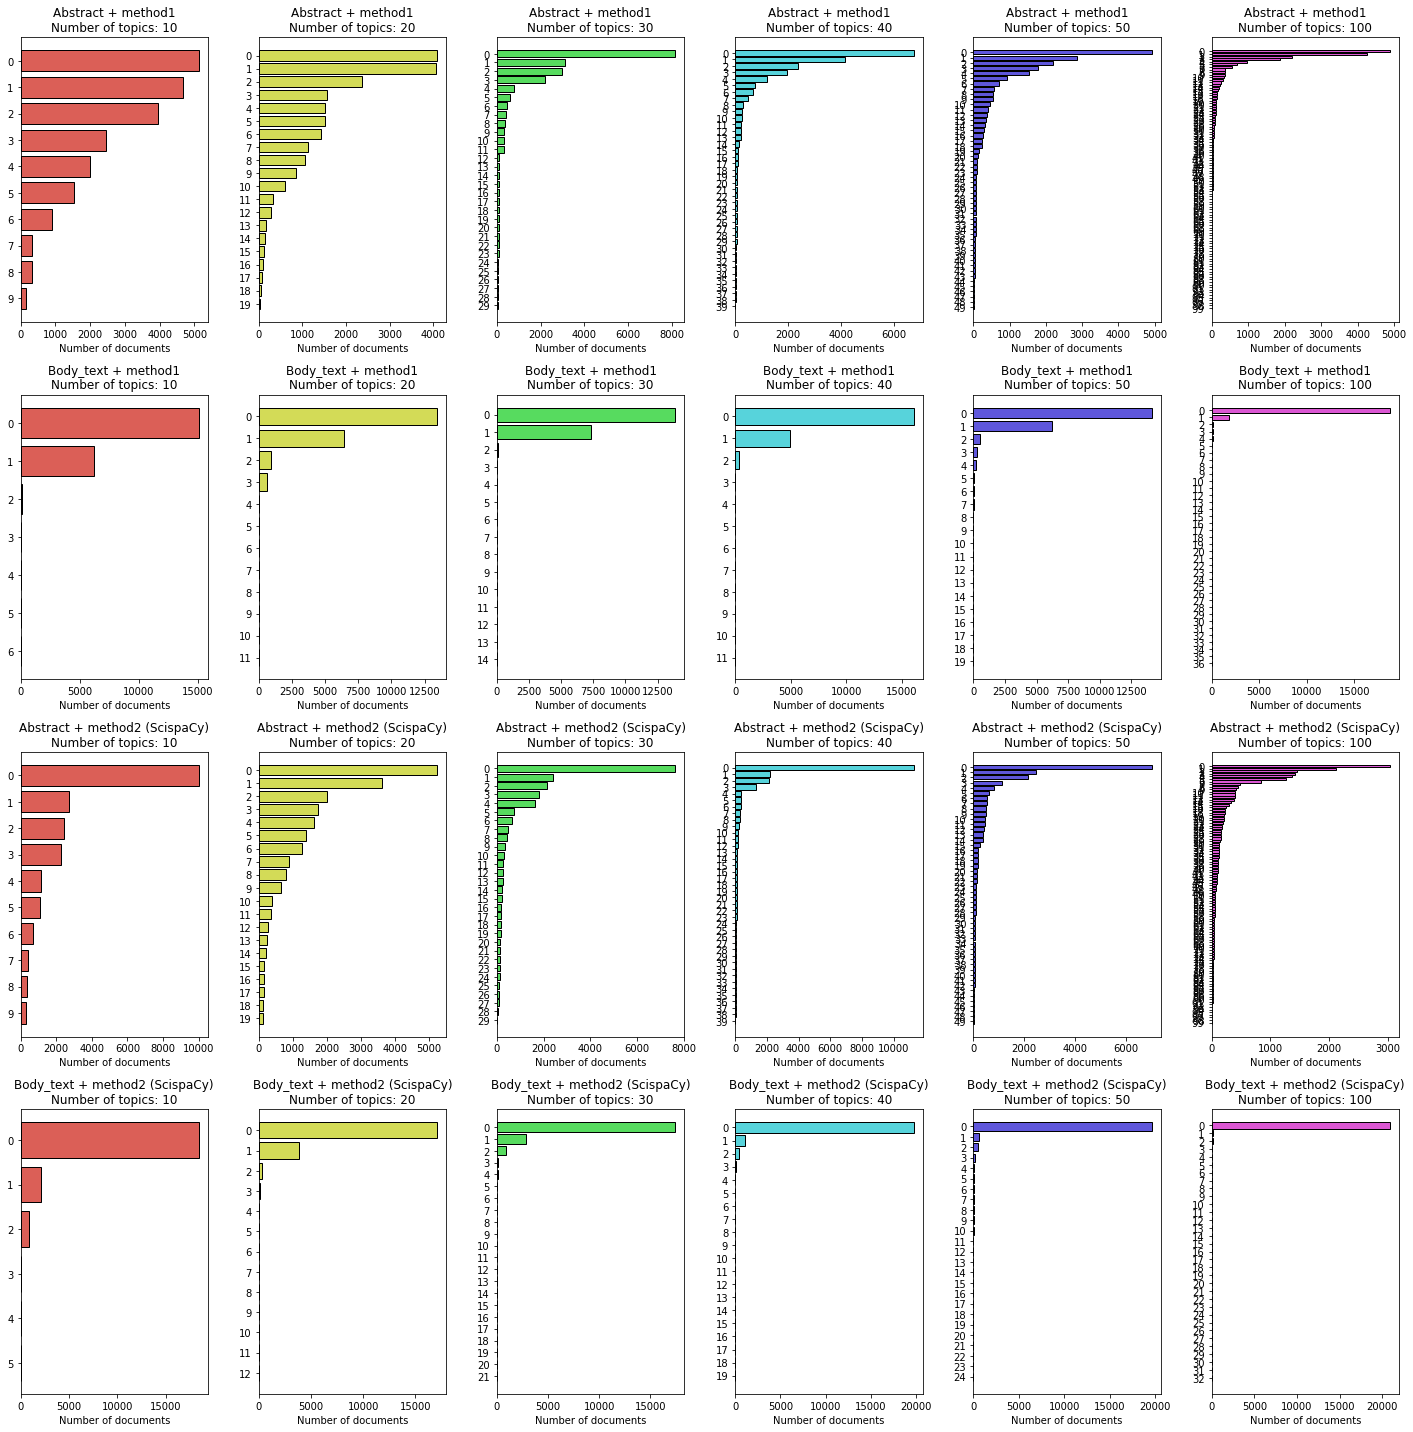

In [300]:
palette=sns.color_palette("hls",6)
fig,axes=plt.subplots(4,6,figsize=(20,20))
for i in range(4):
    for j in range(6):
        file=files[i][j]
        axes[i][j].barh(np.arange(len(file)),file.pred,edgecolor="black",color=palette[j])
        axes[i][j].set_yticks(np.arange(len(file)))
        #axes[i][j].set_yticklabels(["Topic{}".format(i) for i in file.index])
        axes[i][j].invert_yaxis()
        axes[i][j].set_title(filename_list2[i]+"\n"+filename_list1[j])
        axes[i][j].set_xlabel("Number of documents")
plt.tight_layout()

<a id='Part3.2_link'></a>
### 3.2 Evaluate the topic prediction performance of LDA models

In [301]:
pred1_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda10_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda10_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred3_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda20_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred4_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda20_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred5_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda30_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred6_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda30_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred7_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda40_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred8_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda40_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred9_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda50_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred10_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda50_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred11_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda100_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred12_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda100_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred13_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda10_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred14_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda10_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred15_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda20_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred16_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda20_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred17_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda30_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred18_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda30_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred19_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda40_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred20_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda40_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred21_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda50_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred22_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda50_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred23_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda100_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred24_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda100_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])

pred25_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda10_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred26_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda10_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred27_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda20_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred28_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda20_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred29_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda30_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred30_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda30_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred31_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda40_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred32_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda40_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred33_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda50_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred34_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda50_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred35_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda100_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred36_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda100_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred37_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda10_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred38_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda10_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred39_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda20_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred40_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda20_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred41_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda30_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred42_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda30_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred43_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda40_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred44_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda40_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred45_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda50_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred46_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda50_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred47_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda100_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred48_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda100_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])

In [302]:
files=[[pred1_df,pred3_df,pred5_df,pred7_df,pred9_df,pred11_df],
       [pred2_df,pred4_df,pred6_df,pred8_df,pred10_df,pred12_df],
       [pred13_df,pred15_df,pred17_df,pred19_df,pred21_df,pred23_df],
       [pred14_df,pred16_df,pred18_df,pred20_df,pred22_df,pred24_df],
       [pred25_df,pred27_df,pred29_df,pred31_df,pred33_df,pred35_df],
       [pred26_df,pred28_df,pred30_df,pred32_df,pred34_df,pred36_df],
       [pred37_df,pred39_df,pred41_df,pred43_df,pred45_df,pred47_df],
       [pred38_df,pred40_df,pred42_df,pred44_df,pred46_df,pred48_df]]
filename_list1=["Number of topics: {}".format(i) for i in [10,20,30,40,50,100]]
filename_list2=["Abstract pred Title","Abstract pred Bodytext","Bodytext pred Title","Bodytext pred Abstract"]
norms=[10,20,30,40,50,100]
bws=[1/10,1/20,1/30,1/40,1/50,1/100]

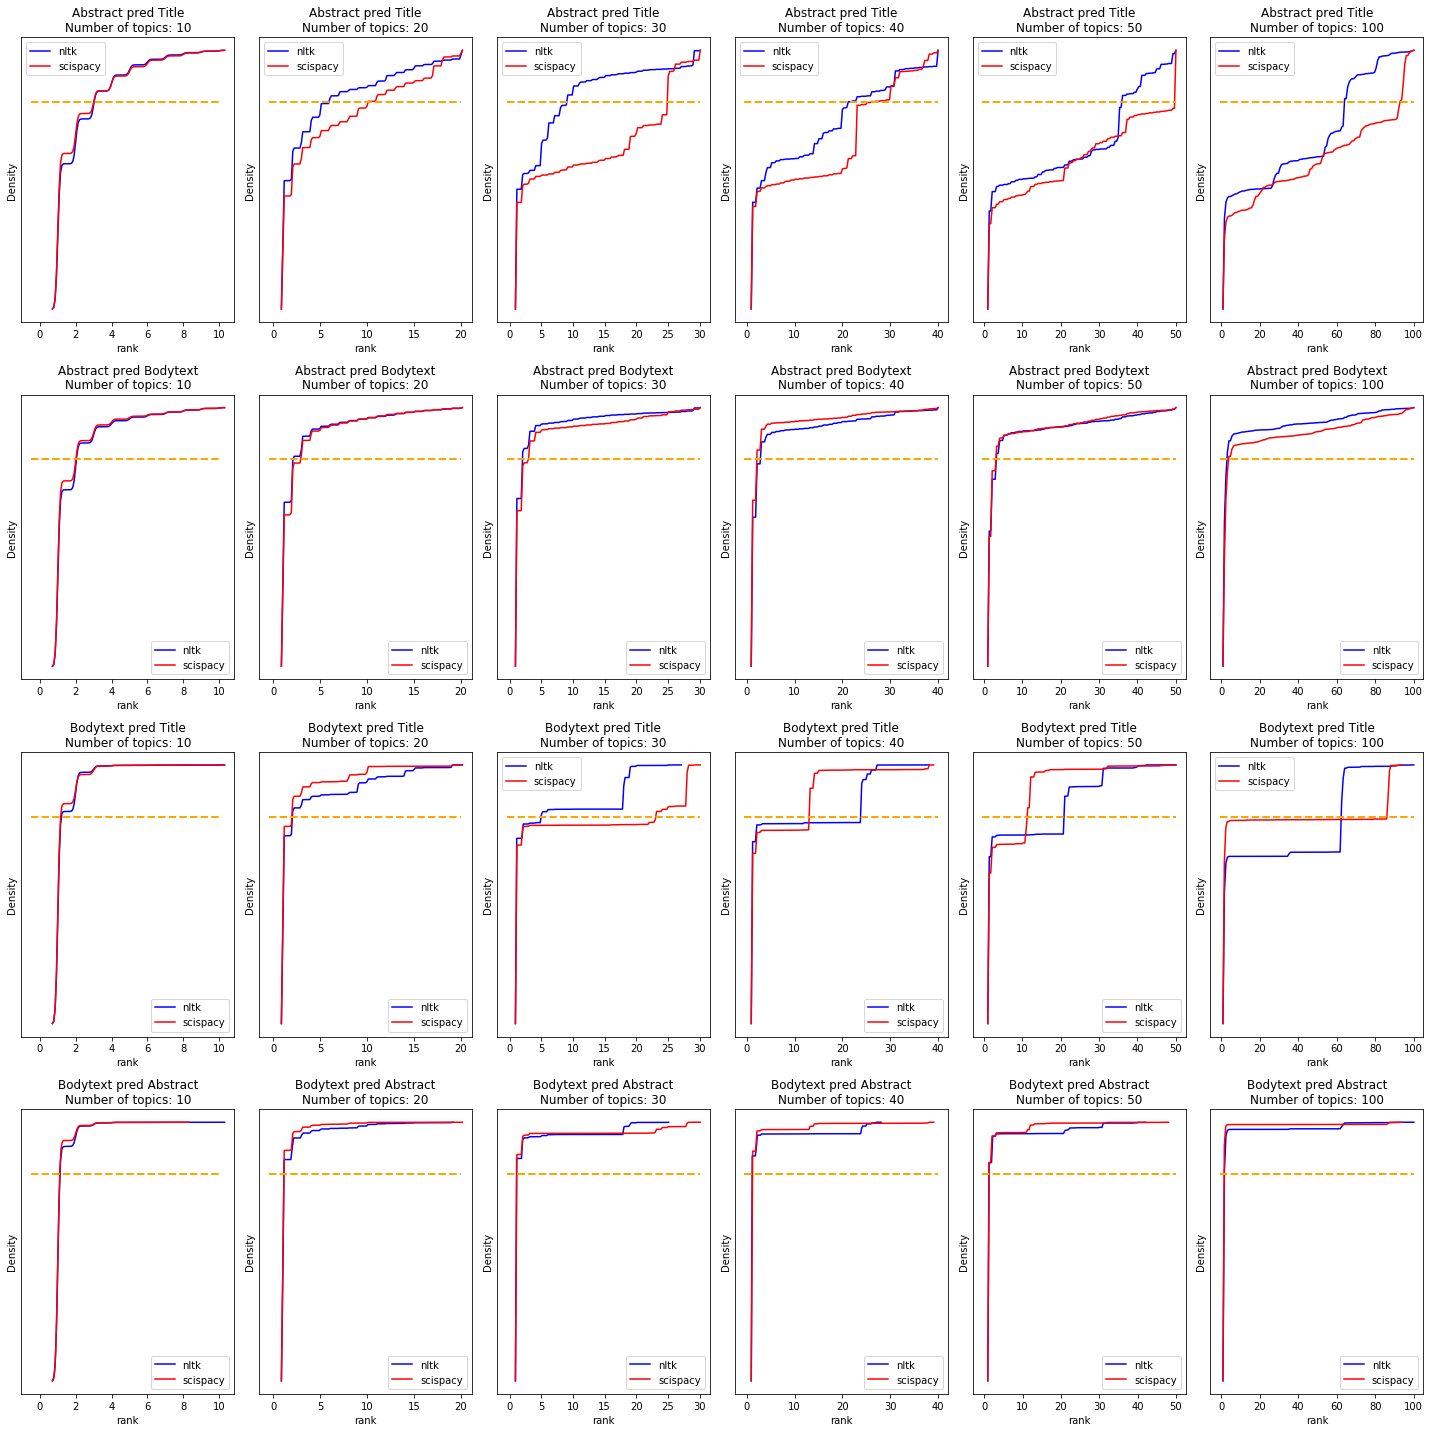

In [303]:
palette=sns.color_palette("hls",6)
fig,axes=plt.subplots(4,6,figsize=(20,20))
for i in range(4):
    for j in range(6):
        file1=files[i][j]
        file2=files[i+4][j]
        sns.distplot(file1["rank"],ax=axes[i][j],hist=False,color="blue",label="nltk",hist_kws={"cumulative":True},kde_kws={"cumulative":True,"bw":bws[j]})
        sns.distplot(file2["rank"],ax=axes[i][j],hist=False,color="red",label="scispacy",hist_kws={"cumulative":True},kde_kws={"cumulative":True,"bw":bws[j]})
        axes[i][j].plot([-0.5,norms[j]],[0.8,0.8],"k--",color="orange",linewidth=2)
        axes[i][j].set_yticks([])
        axes[i][j].set_ylabel("Density")
        axes[i][j].set_title(filename_list2[i]+"\n"+filename_list1[j])
plt.tight_layout()

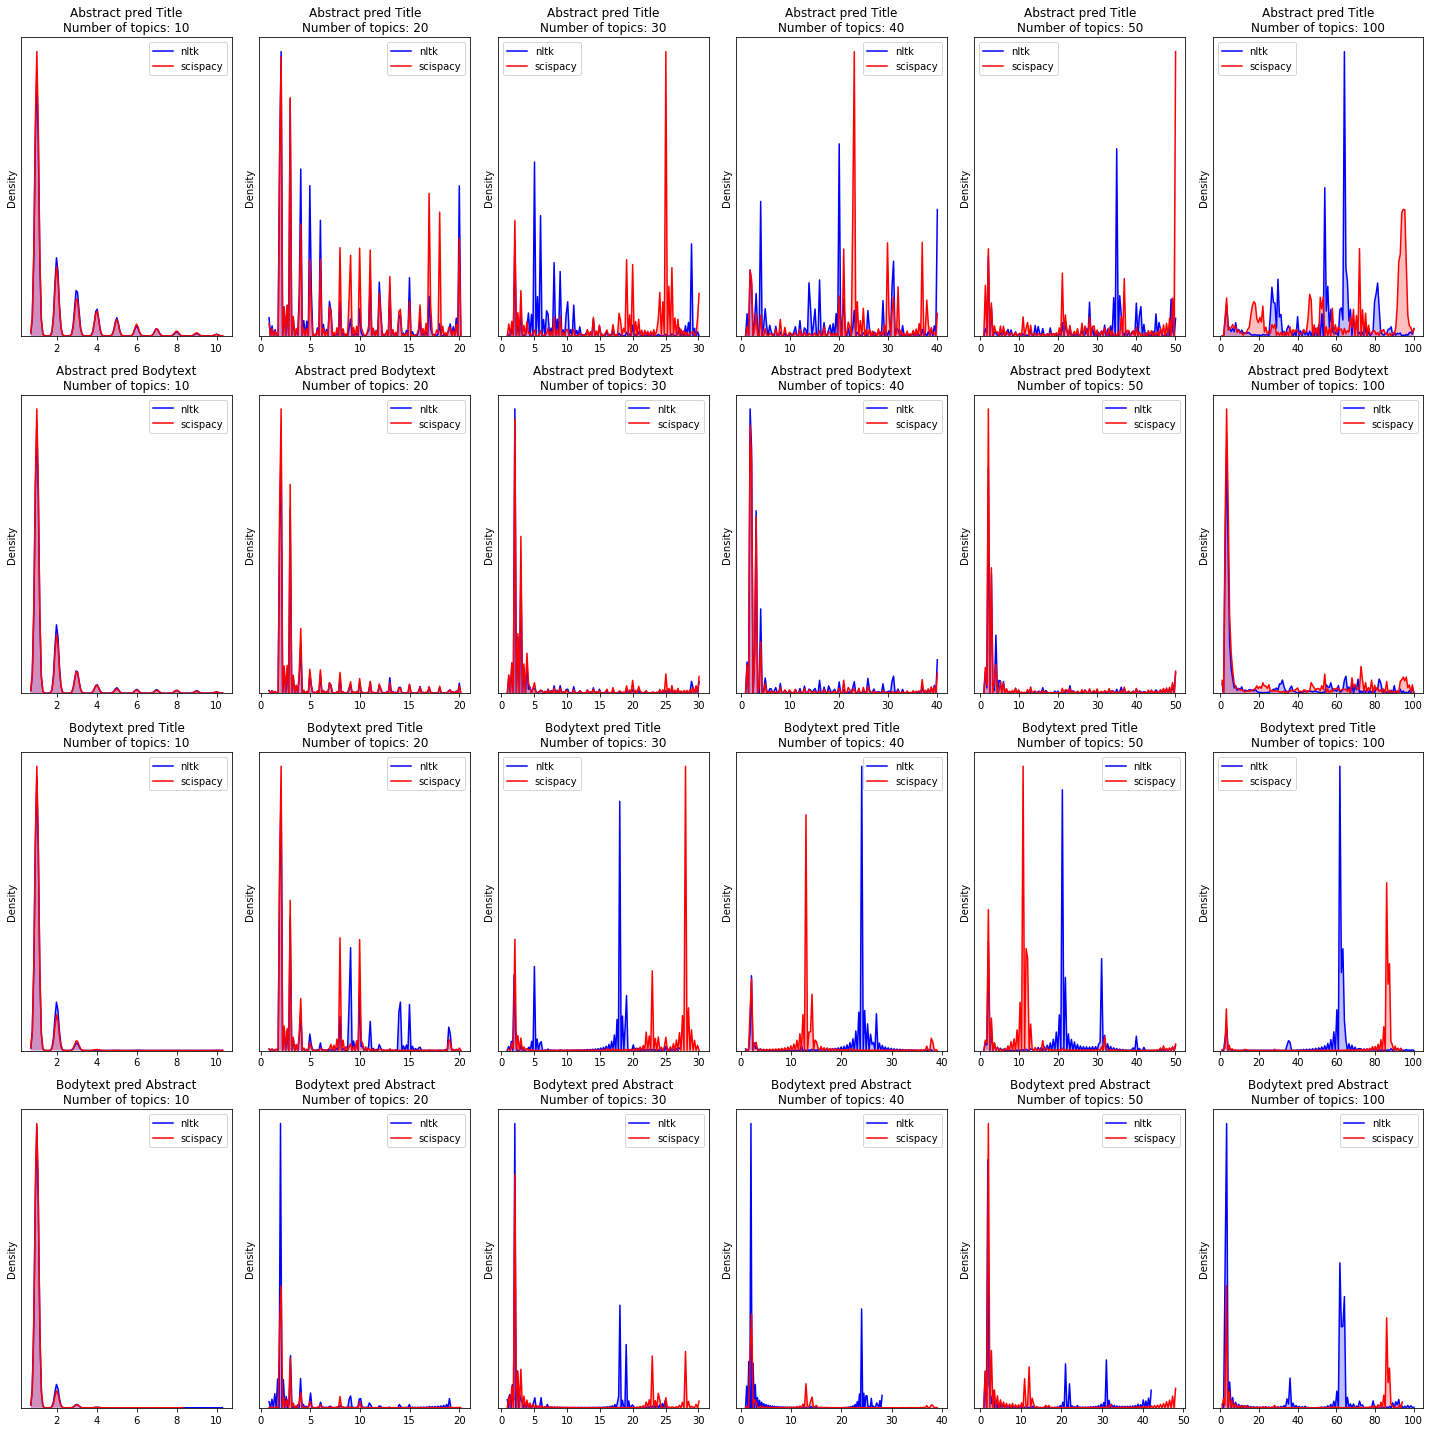

In [304]:
palette=sns.color_palette("hls",6)
fig,axes=plt.subplots(4,6,figsize=(20,20))
for i in range(4):
    for j in range(6):
        file1=files[i][j]
        file2=files[i+4][j]
        sns.kdeplot(file1["rank"],ax=axes[i][j],shade=True,color="blue",label="nltk",bw=bws[j])
        sns.kdeplot(file2["rank"],ax=axes[i][j],shade=True,color="red",label="scispacy",bw=bws[j])
        #axes[i][j].plot([-0.5,norms[j]],[0.8,0.8],"k--",color="orange",linewidth=2)
        axes[i][j].set_yticks([])
        axes[i][j].set_ylabel("Density")
        axes[i][j].set_title(filename_list2[i]+"\n"+filename_list1[j])
plt.tight_layout()

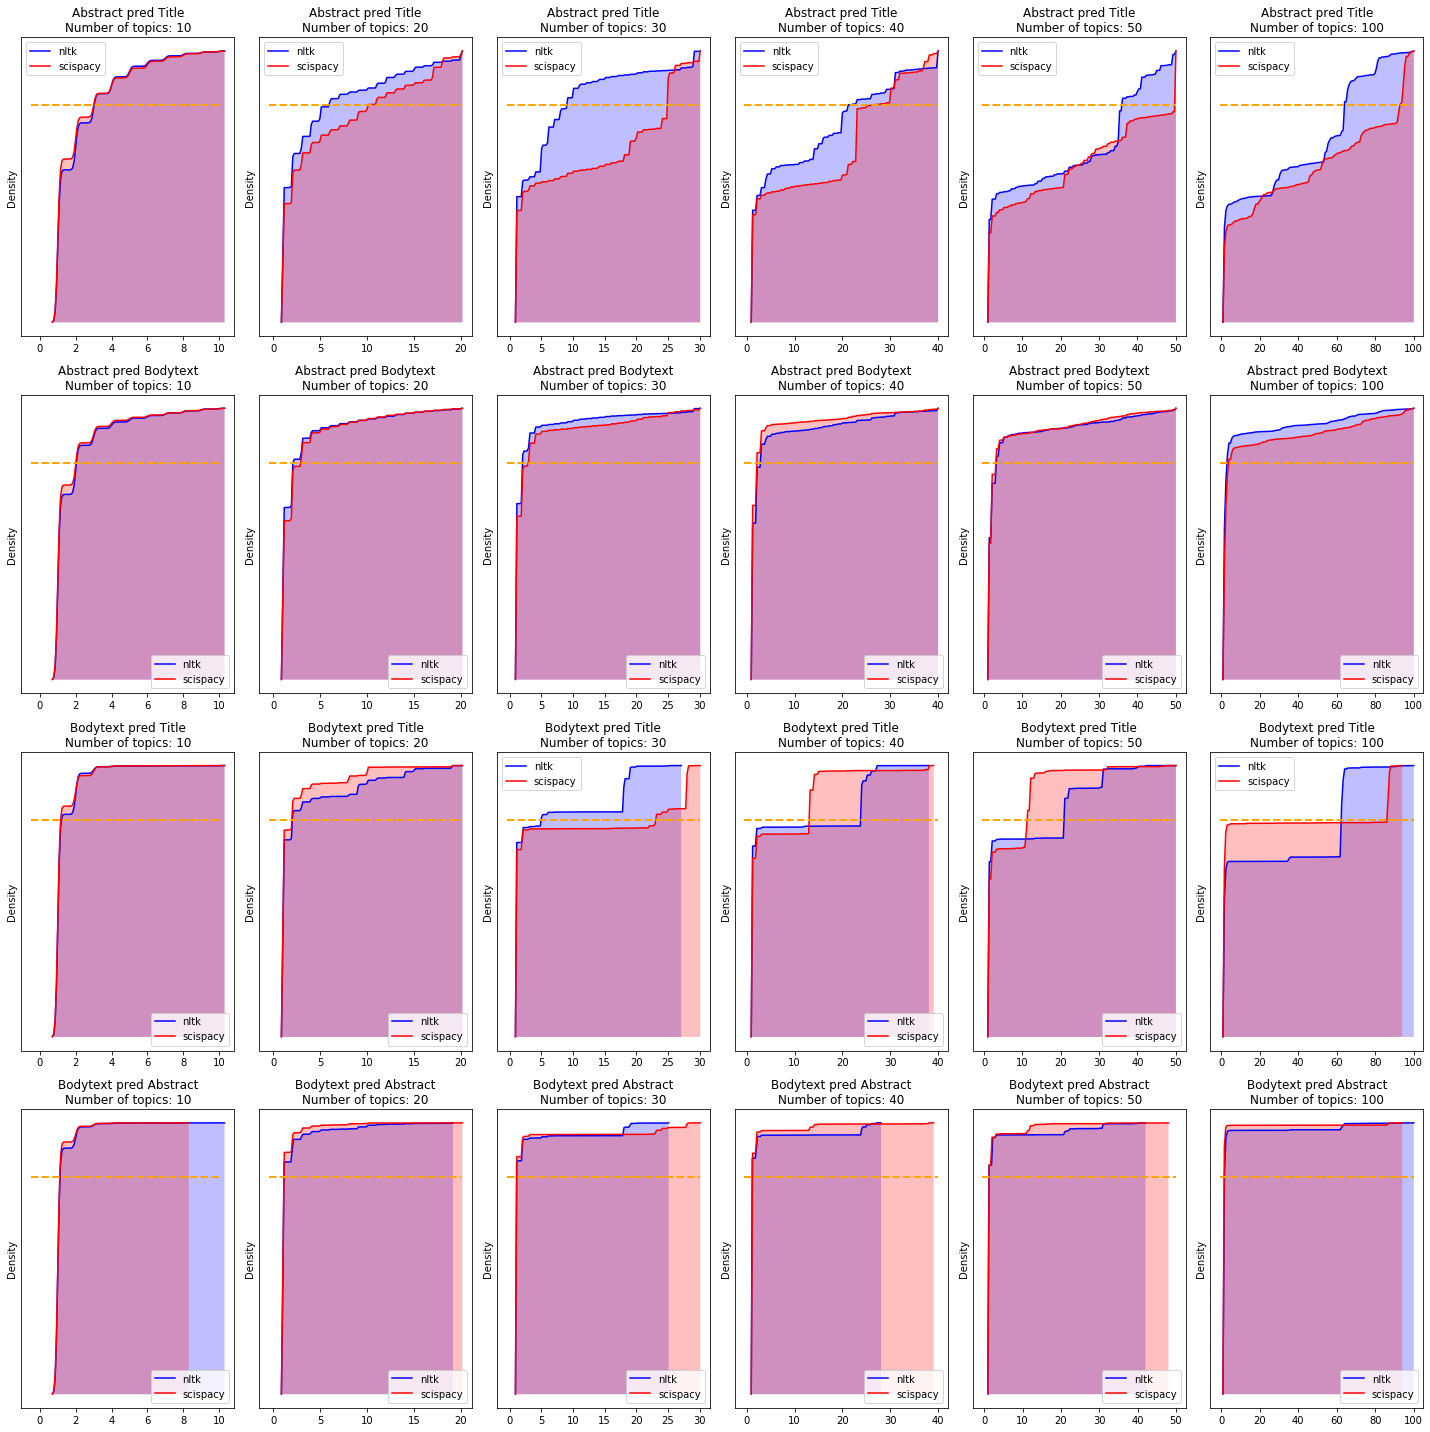

In [305]:
palette=sns.color_palette("hls",6)
fig,axes=plt.subplots(4,6,figsize=(20,20))
for i in range(4):
    for j in range(6):
        file1=files[i][j]
        file2=files[i+4][j]
        sns.kdeplot(file1["rank"],ax=axes[i][j],shade=True,color="blue",label="nltk",bw=bws[j],cumulative=True)
        sns.kdeplot(file2["rank"],ax=axes[i][j],shade=True,color="red",label="scispacy",bw=bws[j],cumulative=True)
        axes[i][j].plot([-0.5,norms[j]],[0.8,0.8],"k--",color="orange",linewidth=2)
        axes[i][j].set_yticks([])
        axes[i][j].set_ylabel("Density")
        axes[i][j].set_title(filename_list2[i]+"\n"+filename_list1[j])
plt.tight_layout()

<a id='Part3.3_link'></a>
### 3.3 Compute cosine similarity for titles, abstracts and bodytext of each paper

In [ ]:
ldavector1_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_ldavector10_df.csv"),index_col="paper_id")
ldavector2_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_ldavector20_df.csv"),index_col="paper_id")
ldavector3_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_ldavector30_df.csv"),index_col="paper_id")
ldavector4_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_ldavector40_df.csv"),index_col="paper_id")
ldavector5_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_ldavector50_df.csv"),index_col="paper_id")
ldavector6_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_ldavector100_df.csv"),index_col="paper_id")
ldavector7_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_ldavector10_df.csv"),index_col="paper_id")
ldavector8_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_ldavector20_df.csv"),index_col="paper_id")
ldavector9_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_ldavector30_df.csv"),index_col="paper_id")
ldavector10_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_ldavector40_df.csv"),index_col="paper_id")
ldavector11_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_ldavector50_df.csv"),index_col="paper_id")
ldavector12_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_ldavector100_df.csv"),index_col="paper_id")
ldavector13_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_ldavector10_df.csv"),index_col="paper_id")
ldavector14_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_ldavector20_df.csv"),index_col="paper_id")
ldavector15_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_ldavector30_df.csv"),index_col="paper_id")
ldavector16_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_ldavector40_df.csv"),index_col="paper_id")
ldavector17_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_ldavector50_df.csv"),index_col="paper_id")
ldavector18_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_ldavector100_df.csv"),index_col="paper_id")
ldavector19_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_ldavector10_df.csv"),index_col="paper_id")
ldavector20_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_ldavector20_df.csv"),index_col="paper_id")
ldavector21_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_ldavector30_df.csv"),index_col="paper_id")
ldavector22_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_ldavector40_df.csv"),index_col="paper_id")
ldavector23_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_ldavector50_df.csv"),index_col="paper_id")
ldavector24_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_ldavector100_df.csv"),index_col="paper_id")


In [3]:
pred1_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda10_df.csv"),index_col="paper_id")
pred2_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda10_df.csv"),index_col="paper_id")
pred3_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda20_df.csv"),index_col="paper_id")
pred4_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda20_df.csv"),index_col="paper_id")
pred5_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda30_df.csv"),index_col="paper_id")
pred6_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda30_df.csv"),index_col="paper_id")
pred7_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda40_df.csv"),index_col="paper_id")
pred8_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda40_df.csv"),index_col="paper_id")
pred9_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda50_df.csv"),index_col="paper_id")
pred10_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda50_df.csv"),index_col="paper_id")
pred11_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda100_df.csv"),index_col="paper_id")
pred12_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda100_df.csv"),index_col="paper_id")
pred13_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda10_df.csv"),index_col="paper_id")
pred14_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda10_df.csv"),index_col="paper_id")
pred15_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda20_df.csv"),index_col="paper_id")
pred16_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda20_df.csv"),index_col="paper_id")
pred17_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda30_df.csv"),index_col="paper_id")
pred18_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda30_df.csv"),index_col="paper_id")
pred19_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda40_df.csv"),index_col="paper_id")
pred20_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda40_df.csv"),index_col="paper_id")
pred21_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda50_df.csv"),index_col="paper_id")
pred22_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda50_df.csv"),index_col="paper_id")
pred23_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda100_df.csv"),index_col="paper_id")
pred24_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda100_df.csv"),index_col="paper_id")

pred25_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda10_df.csv"),index_col="paper_id")
pred26_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda10_df.csv"),index_col="paper_id")
pred27_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda20_df.csv"),index_col="paper_id")
pred28_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda20_df.csv"),index_col="paper_id")
pred29_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda30_df.csv"),index_col="paper_id")
pred30_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda30_df.csv"),index_col="paper_id")
pred31_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda40_df.csv"),index_col="paper_id")
pred32_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda40_df.csv"),index_col="paper_id")
pred33_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda50_df.csv"),index_col="paper_id")
pred34_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda50_df.csv"),index_col="paper_id")
pred35_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda100_df.csv"),index_col="paper_id")
pred36_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda100_df.csv"),index_col="paper_id")
pred37_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda10_df.csv"),index_col="paper_id")
pred38_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda10_df.csv"),index_col="paper_id")
pred39_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda20_df.csv"),index_col="paper_id")
pred40_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda20_df.csv"),index_col="paper_id")
pred41_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda30_df.csv"),index_col="paper_id")
pred42_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda30_df.csv"),index_col="paper_id")
pred43_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda40_df.csv"),index_col="paper_id")
pred44_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda40_df.csv"),index_col="paper_id")
pred45_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda50_df.csv"),index_col="paper_id")
pred46_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda50_df.csv"),index_col="paper_id")
pred47_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda100_df.csv"),index_col="paper_id")
pred48_v2_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda100_df.csv"),index_col="paper_id")


In [ ]:
def get_similarity_rank(ldavector_df,query,paper_id):
    cos_sim=cosine_similarity(X=ldavector_df,Y=query)
    cos_sim_df=pd.DataFrame({"paper_id":ldavector_df.index,"cosine_similarity":cos_sim.squeeze()}).sort_values(by=["cosine_similarity"],ascending=False).reset_index().drop(["index"],axis=1)
    return int(cos_sim_df[cos_sim_df.paper_id==paper_id].index.values)

In [ ]:
pred1_v2_df["paper_id"]=pred1_v2_df.index
pred1_v2_df["cosine_similarity_rank"]=pred1_v2_df.apply(lambda x:get_similarity_rank(ldavector1_v2_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred1_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda10_df.csv"),index=False)

In [ ]:
pred2_v2_df["paper_id"]=pred2_v2_df.index
pred2_v2_df["cosine_similarity_rank"]=pred2_v2_df.apply(lambda x:get_similarity_rank(ldavector1_v2_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred2_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda10_df.csv"),index=False)

In [ ]:
pred3_v2_df["paper_id"]=pred3_v2_df.index
pred3_v2_df["cosine_similarity_rank"]=pred3_v2_df.apply(lambda x:get_similarity_rank(ldavector2_v2_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred3_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda20_df.csv"),index=False)

In [ ]:
pred4_v2_df["paper_id"]=pred4_v2_df.index
pred4_v2_df["cosine_similarity_rank"]=pred4_v2_df.apply(lambda x:get_similarity_rank(ldavector2_v2_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred4_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda20_df.csv"),index=False)


In [ ]:
pred5_v2_df["paper_id"]=pred5_v2_df.index
pred5_v2_df["cosine_similarity_rank"]=pred5_v2_df.apply(lambda x:get_similarity_rank(ldavector3_v2_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred5_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda30_df.csv"),index=False)


In [ ]:
pred6_v2_df["paper_id"]=pred6_v2_df.index
pred6_v2_df["cosine_similarity_rank"]=pred6_v2_df.apply(lambda x:get_similarity_rank(ldavector3_v2_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred6_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda30_df.csv"),index=False)


In [ ]:
pred7_v2_df["paper_id"]=pred7_v2_df.index
pred7_v2_df["cosine_similarity_rank"]=pred7_v2_df.apply(lambda x:get_similarity_rank(ldavector4_v2_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred7_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda40_df.csv"),index=False)


In [ ]:
pred8_v2_df["paper_id"]=pred8_v2_df.index
pred8_v2_df["cosine_similarity_rank"]=pred8_v2_df.apply(lambda x:get_similarity_rank(ldavector4_v2_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred8_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda40_df.csv"),index=False)


In [ ]:
pred9_v2_df["paper_id"]=pred9_v2_df.index
pred9_v2_df["cosine_similarity_rank"]=pred9_v2_df.apply(lambda x:get_similarity_rank(ldavector5_v2_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred9_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda50_df.csv"),index=False)


In [ ]:
pred10_v2_df["paper_id"]=pred10_v2_df.index
pred10_v2_df["cosine_similarity_rank"]=pred10_v2_df.apply(lambda x:get_similarity_rank(ldavector5_v2_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred10_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda50_df.csv"),index=False)


In [ ]:
pred11_v2_df["paper_id"]=pred11_v2_df.index
pred11_v2_df["cosine_similarity_rank"]=pred11_v2_df.apply(lambda x:get_similarity_rank(ldavector6_v2_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred11_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda100_df.csv"),index=False)


In [ ]:
pred12_v2_df["paper_id"]=pred12_v2_df.index
pred12_v2_df["cosine_similarity_rank"]=pred12_v2_df.apply(lambda x:get_similarity_rank(ldavector6_v2_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred12_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda100_df.csv"),index=False)


In [ ]:
pred13_v2_df["paper_id"]=pred13_v2_df.index
pred13_v2_df["cosine_similarity_rank"]=pred13_v2_df.apply(lambda x:get_similarity_rank(ldavector7_v2_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred13_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda10_df.csv"),index=False)


In [ ]:
pred14_v2_df["paper_id"]=pred14_v2_df.index
pred14_v2_df["cosine_similarity_rank"]=pred14_v2_df.apply(lambda x:get_similarity_rank(ldavector7_v2_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred14_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda10_df.csv"),index=False)


In [ ]:
pred15_v2_df["paper_id"]=pred15_v2_df.index
pred15_v2_df["cosine_similarity_rank"]=pred15_v2_df.apply(lambda x:get_similarity_rank(ldavector8_v2_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred15_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda20_df.csv"),index=False)


In [ ]:
pred16_v2_df["paper_id"]=pred16_v2_df.index
pred16_v2_df["cosine_similarity_rank"]=pred16_v2_df.apply(lambda x:get_similarity_rank(ldavector8_v2_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred16_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda20_df.csv"),index=False)


In [ ]:
pred17_v2_df["paper_id"]=pred17_v2_df.index
pred17_v2_df["cosine_similarity_rank"]=pred17_v2_df.apply(lambda x:get_similarity_rank(ldavector9_v2_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred17_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda30_df.csv"),index=False)


In [ ]:
pred18_v2_df["paper_id"]=pred18_v2_df.index
pred18_v2_df["cosine_similarity_rank"]=pred18_v2_df.apply(lambda x:get_similarity_rank(ldavector9_v2_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred18_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda30_df.csv"),index=False)


In [ ]:
pred19_v2_df["paper_id"]=pred19_v2_df.index
pred19_v2_df["cosine_similarity_rank"]=pred19_v2_df.apply(lambda x:get_similarity_rank(ldavector10_v2_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred19_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda40_df.csv"),index=False)


In [ ]:
pred20_v2_df["paper_id"]=pred20_v2_df.index
pred20_v2_df["cosine_similarity_rank"]=pred20_v2_df.apply(lambda x:get_similarity_rank(ldavector10_v2_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred20_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda40_df.csv"),index=False)


In [ ]:
pred21_v2_df["paper_id"]=pred21_v2_df.index
pred21_v2_df["cosine_similarity_rank"]=pred21_v2_df.apply(lambda x:get_similarity_rank(ldavector11_v2_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred21_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda50_df.csv"),index=False)


In [ ]:
pred22_v2_df["paper_id"]=pred22_v2_df.index
pred22_v2_df["cosine_similarity_rank"]=pred22_v2_df.apply(lambda x:get_similarity_rank(ldavector11_v2_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred22_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda50_df.csv"),index=False)


In [ ]:
pred23_v2_df["paper_id"]=pred23_v2_df.index
pred23_v2_df["cosine_similarity_rank"]=pred23_v2_df.apply(lambda x:get_similarity_rank(ldavector12_v2_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred23_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda100_df.csv"),index=False)


In [ ]:
pred24_v2_df["paper_id"]=pred24_v2_df.index
pred24_v2_df["cosine_similarity_rank"]=pred24_v2_df.apply(lambda x:get_similarity_rank(ldavector12_v2_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred24_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda100_df.csv"),index=False)


In [ ]:
pred25_v2_df["paper_id"]=pred25_v2_df.index
pred25_v2_df["cosine_similarity_rank"]=pred25_v2_df.apply(lambda x:get_similarity_rank(ldavector13_v2_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred25_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda10_df.csv"),index=False)


In [ ]:
pred26_v2_df["paper_id"]=pred26_v2_df.index
pred26_v2_df["cosine_similarity_rank"]=pred26_v2_df.apply(lambda x:get_similarity_rank(ldavector13_v2_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred26_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda10_df.csv"),index=False)


In [ ]:
pred27_v2_df["paper_id"]=pred27_v2_df.index
pred27_v2_df["cosine_similarity_rank"]=pred27_v2_df.apply(lambda x:get_similarity_rank(ldavector14_v2_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred27_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda20_df.csv"),index=False)


In [ ]:
pred28_v2_df["paper_id"]=pred28_v2_df.index
pred28_v2_df["cosine_similarity_rank"]=pred28_v2_df.apply(lambda x:get_similarity_rank(ldavector14_v2_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred28_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda20_df.csv"),index=False)


In [ ]:
pred29_v2_df["paper_id"]=pred29_v2_df.index
pred29_v2_df["cosine_similarity_rank"]=pred29_v2_df.apply(lambda x:get_similarity_rank(ldavector15_v2_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred29_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda30_df.csv"),index=False)


In [ ]:
pred30_v2_df["paper_id"]=pred30_v2_df.index
pred30_v2_df["cosine_similarity_rank"]=pred30_v2_df.apply(lambda x:get_similarity_rank(ldavector15_v2_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred30_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda30_df.csv"),index=False)


In [ ]:
pred31_v2_df["paper_id"]=pred31_v2_df.index
pred31_v2_df["cosine_similarity_rank"]=pred31_v2_df.apply(lambda x:get_similarity_rank(ldavector16_v2_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred31_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda40_df.csv"),index=False)


In [ ]:
pred32_v2_df["paper_id"]=pred32_v2_df.index
pred32_v2_df["cosine_similarity_rank"]=pred32_v2_df.apply(lambda x:get_similarity_rank(ldavector16_v2_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred32_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda40_df.csv"),index=False)


In [ ]:
pred33_v2_df["paper_id"]=pred33_v2_df.index
pred33_v2_df["cosine_similarity_rank"]=pred33_v2_df.apply(lambda x:get_similarity_rank(ldavector17_v2_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred33_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda50_df.csv"),index=False)


In [ ]:
pred34_v2_df["paper_id"]=pred34_v2_df.index
pred34_v2_df["cosine_similarity_rank"]=pred34_v2_df.apply(lambda x:get_similarity_rank(ldavector17_v2_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred34_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda50_df.csv"),index=False)


In [ ]:
pred35_v2_df["paper_id"]=pred35_v2_df.index
pred35_v2_df["cosine_similarity_rank"]=pred35_v2_df.apply(lambda x:get_similarity_rank(ldavector18_v2_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred35_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda100_df.csv"),index=False)


In [ ]:
pred36_v2_df["paper_id"]=pred36_v2_df.index
pred36_v2_df["cosine_similarity_rank"]=pred36_v2_df.apply(lambda x:get_similarity_rank(ldavector18_v2_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred36_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda100_df.csv"),index=False)


In [ ]:
pred37_v2_df["paper_id"]=pred37_v2_df.index
pred37_v2_df["cosine_similarity_rank"]=pred37_v2_df.apply(lambda x:get_similarity_rank(ldavector19_v2_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred37_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda10_df.csv"),index=False)


In [ ]:
pred38_v2_df["paper_id"]=pred38_v2_df.index
pred38_v2_df["cosine_similarity_rank"]=pred38_v2_df.apply(lambda x:get_similarity_rank(ldavector19_v2_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred38_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda10_df.csv"),index=False)


In [ ]:
pred39_v2_df["paper_id"]=pred39_v2_df.index
pred39_v2_df["cosine_similarity_rank"]=pred39_v2_df.apply(lambda x:get_similarity_rank(ldavector20_v2_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred39_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda20_df.csv"),index=False)


In [ ]:
pred40_v2_df["paper_id"]=pred40_v2_df.index
pred40_v2_df["cosine_similarity_rank"]=pred40_v2_df.apply(lambda x:get_similarity_rank(ldavector20_v2_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred40_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda20_df.csv"),index=False)


In [ ]:
pred41_v2_df["paper_id"]=pred41_v2_df.index
pred41_v2_df["cosine_similarity_rank"]=pred41_v2_df.apply(lambda x:get_similarity_rank(ldavector21_v2_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred41_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda30_df.csv"),index=False)


In [ ]:
pred42_v2_df["paper_id"]=pred42_v2_df.index
pred42_v2_df["cosine_similarity_rank"]=pred42_v2_df.apply(lambda x:get_similarity_rank(ldavector21_v2_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred42_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda30_df.csv"),index=False)


In [ ]:
pred43_v2_df["paper_id"]=pred43_v2_df.index
pred43_v2_df["cosine_similarity_rank"]=pred43_v2_df.apply(lambda x:get_similarity_rank(ldavector22_v2_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred43_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda40_df.csv"),index=False)


In [ ]:
pred44_v2_df["paper_id"]=pred44_v2_df.index
pred44_v2_df["cosine_similarity_rank"]=pred44_v2_df.apply(lambda x:get_similarity_rank(ldavector22_v2_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred44_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda40_df.csv"),index=False)


In [ ]:
pred45_v2_df["paper_id"]=pred45_v2_df.index
pred45_v2_df["cosine_similarity_rank"]=pred45_v2_df.apply(lambda x:get_similarity_rank(ldavector23_v2_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred45_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda50_df.csv"),index=False)


In [ ]:
pred46_v2_df["paper_id"]=pred46_v2_df.index
pred46_v2_df["cosine_similarity_rank"]=pred46_v2_df.apply(lambda x:get_similarity_rank(ldavector23_v2_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred46_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda50_df.csv"),index=False)


In [ ]:
pred47_v2_df["paper_id"]=pred47_v2_df.index
pred47_v2_df["cosine_similarity_rank"]=pred47_v2_df.apply(lambda x:get_similarity_rank(ldavector24_v2_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred47_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda100_df.csv"),index=False)


In [ ]:
pred48_v2_df["paper_id"]=pred48_v2_df.index
pred48_v2_df["cosine_similarity_rank"]=pred48_v2_df.apply(lambda x:get_similarity_rank(ldavector24_v2_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred48_v2_df.to_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda100_df.csv"),index=False)


<a id='Part3.4_link'></a>
### 3.4 Evaluate cosine similarity

In [11]:
pred_files_v2=[pred1_v2_df,pred3_v2_df,pred5_v2_df,pred7_v2_df,pred9_v2_df,pred11_v2_df,
               pred2_v2_df,pred4_v2_df,pred6_v2_df,pred8_v2_df,pred10_v2_df,pred12_v2_df,
               pred13_v2_df,pred15_v2_df,pred17_v2_df,pred19_v2_df,pred21_v2_df,pred23_v2_df,
               pred14_v2_df,pred16_v2_df,pred18_v2_df,pred20_v2_df,pred22_v2_df,pred24_v2_df,
               pred25_v2_df,pred27_v2_df,pred29_v2_df,pred31_v2_df,pred33_v2_df,pred35_v2_df,
               pred26_v2_df,pred28_v2_df,pred30_v2_df,pred32_v2_df,pred34_v2_df,pred36_v2_df,
               pred37_v2_df,pred39_v2_df,pred41_v2_df,pred43_v2_df,pred45_v2_df,pred47_v2_df,
               pred38_v2_df,pred40_v2_df,pred42_v2_df,pred44_v2_df,pred46_v2_df,pred48_v2_df]


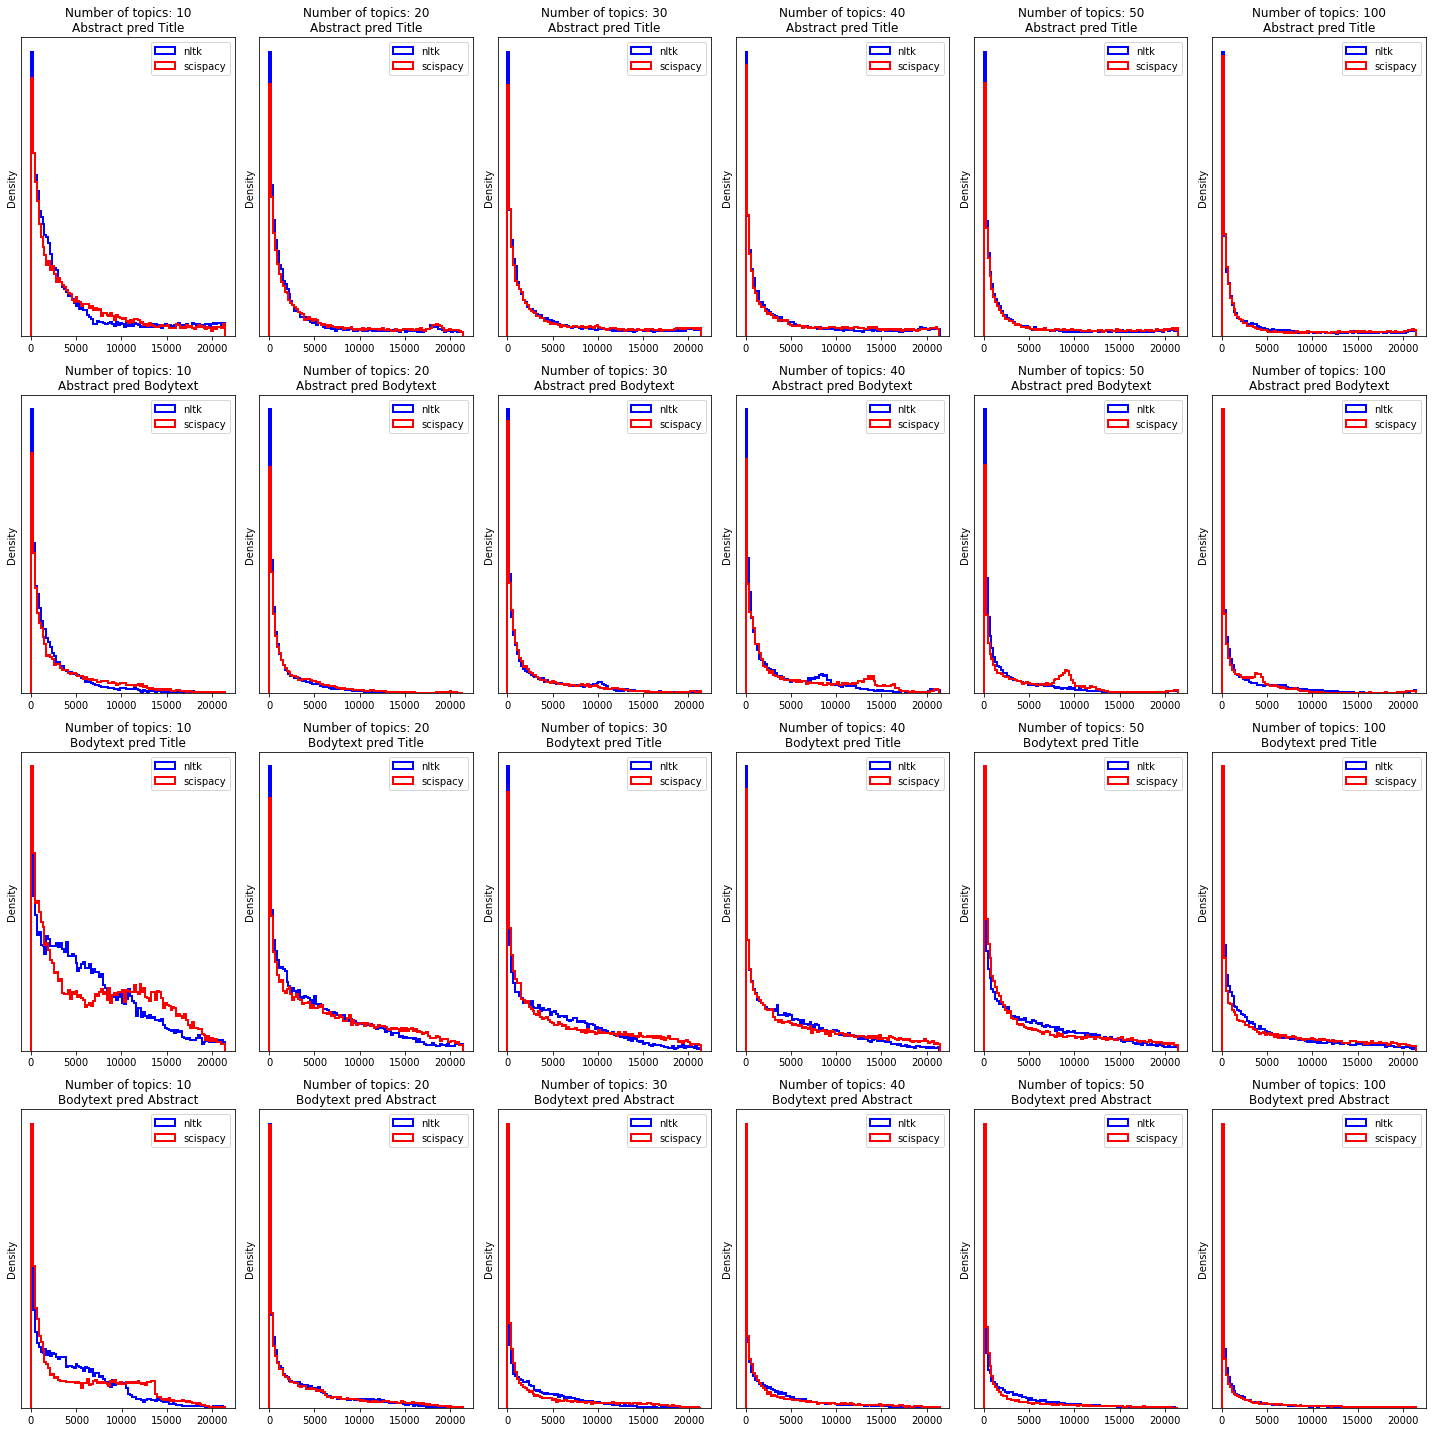

In [12]:
## compare nltk and scispacy
filename_list1=["Number of topics: {}".format(i) for i in [10,20,30,40,50,100]]
filename_list2=["Abstract pred Title","Abstract pred Bodytext","Bodytext pred Title","Bodytext pred Abstract"]

fig,axes=plt.subplots(4,6,figsize=(20,20))
for i in range(24):
    file1=pred_files_v2[i]
    file2=pred_files_v2[i+24]
    axes[i//6][i%6].hist(file1["cosine_similarity_rank"],bins=100,histtype="step",color="blue",label="nltk",linewidth=2)
    axes[i//6][i%6].hist(file2["cosine_similarity_rank"],bins=100,histtype="step",color="red",label="scispacy",linewidth=2)
    axes[i//6][i%6].set_yticks([])
    axes[i//6][i%6].set_ylabel("Density")
    axes[i//6][i%6].set_title(filename_list1[i%6]+"\n"+filename_list2[i//6])
    axes[i//6][i%6].legend()
plt.tight_layout()

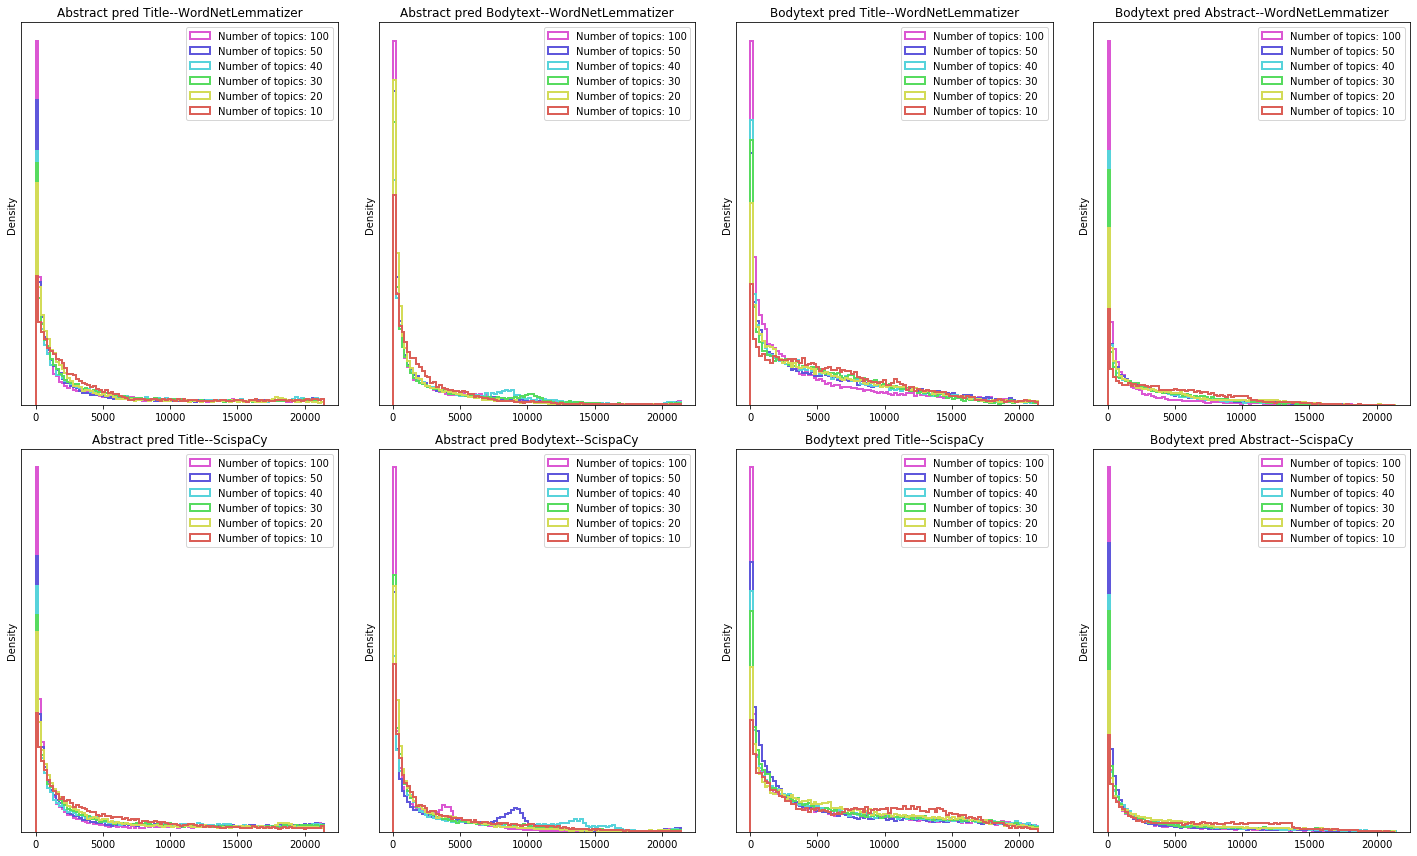

In [16]:
filename_list3=["Abstract pred Title--WordNetLemmatizer","Abstract pred Bodytext--WordNetLemmatizer","Bodytext pred Title--WordNetLemmatizer","Bodytext pred Abstract--WordNetLemmatizer",
                "Abstract pred Title--ScispaCy","Abstract pred Bodytext--ScispaCy","Bodytext pred Title--ScispaCy","Bodytext pred Abstract--ScispaCy"]
palette=sns.color_palette("hls",6)

fig,axes=plt.subplots(2,4,figsize=(20,12))
for i in range(7,-1,-1):
    for j in range(5,-1,-1):
        file=pred_files_v2[i*6+j]
        axes[i//4][i%4].hist(file["cosine_similarity_rank"],bins=100,histtype="step",color=palette[j],label=filename_list1[j],linewidth=2)
    axes[i//4][i%4].set_yticks([])
    axes[i//4][i%4].set_ylabel("Density")
    axes[i//4][i%4].set_title(filename_list3[i])
    axes[i//4][i%4].legend()
plt.tight_layout()

<a id='Part4_link'></a>
## 4. Visualize keywords in each LDA topic using WordCloud

In [17]:
data_df=pd.read_csv(os.path.join(base_dir,"COVD19_meta_21423_text_all_df.csv"),index_col="paper_id",
                    dtype={"pubmed_id":str},
                    converters={"title2":literal_eval,"abstract2":literal_eval,"body_text2":literal_eval,
                                "title3":literal_eval,"abstract3":literal_eval,"body_text3":literal_eval},
                    parse_dates=["publish_time"])

In [20]:
pred_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda10_df.csv"),index_col="paper_id")


In [29]:
stop_words=pickle.load(open(os.path.join(base_dir,"stop_words.pkl"),"rb"))
print(len(stop_words))

546


/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


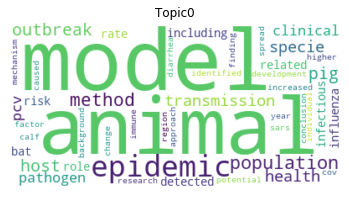

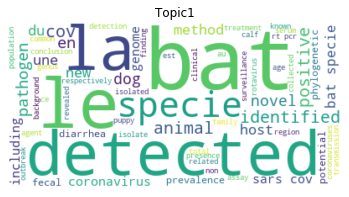

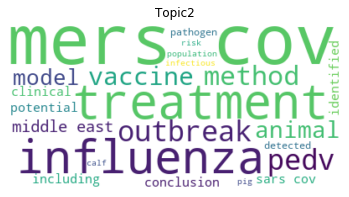

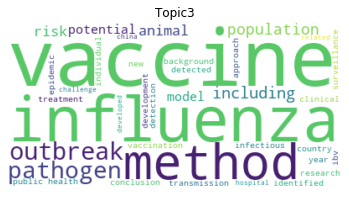

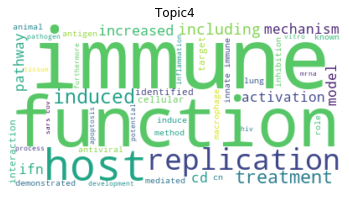

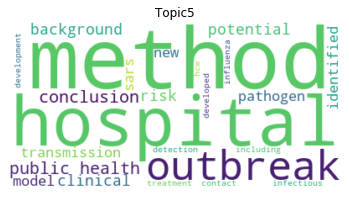

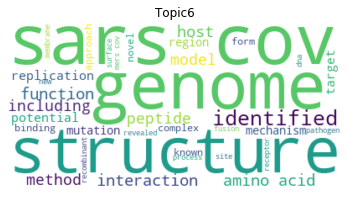

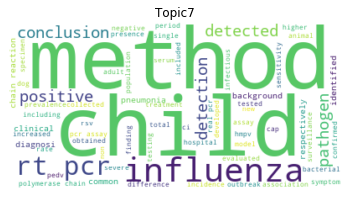

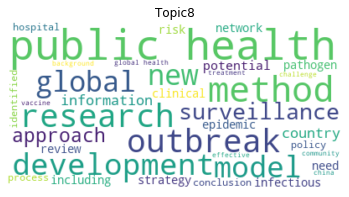

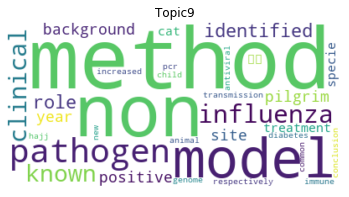

In [39]:
for i in range(10):
    subset_df=data_df[pred_df.pred==i]
    subset_df["corpus"]=subset_df.abstract2.apply(lambda x: " ".join(x))
    wc = WordCloud(background_color="white",
                   stopwords=stop_words,
                   max_words=500,
                   max_font_size=100,
                   min_font_size=8,
                   random_state=42,
                   mode="RGBA").generate(" ".join(subset_df.corpus))
    plt.figure()
    plt.title("Topic{}".format(i),fontsize=12)
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.savefig(os.path.join(base_dir, 'wordcloud/topic{}_wordcloud.png'.format(i)))

## Conclusion
<br> 1. **WordNetLemmatizer** and **ScispaCy** have comparable performance in preprocessing text
<br> 2. In general, increased number of topics in LDA analysis has better embedding performance based on the cosine similarity score rank among abstracts/titles/bodytext for each paper
<br> 3. LDA models built on abstract and bodytext can predict topics for bodytext/title and abstract, but the model built on bodytext has a suboptimal performance predicting titles with small topic number.